<a href="https://colab.research.google.com/github/o-sapohova/Sales-analysis/blob/main/Sales_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connection to a database**

In [ ]:
from google.colab import auth, drive, files
from google.cloud import bigquery
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, normaltest, shapiro, mannwhitneyu, kruskal
import itertools
import scipy.stats as stats
import statsmodels.api as sm

auth.authenticate_user()
client = bigquery.Client(project="data-analytics-mate")

query = """
WITH
  account_data AS (
  SELECT
    acs.ga_session_id,
    acs.account_id,
    a.is_verified,
    a.is_unsubscribed
  FROM
    `DA.account_session` acs
  JOIN
    `DA.account` a
  ON
    acs.account_id = a.id ),
  orders_data AS (
  SELECT
    o.ga_session_id,
    p.category,
    p.name AS product_name,
    p.price,
    p.short_description
  FROM
    `DA.order` o
  JOIN
    `DA.product` p
  ON
    o.item_id = p.item_id )
SELECT
  s.date,
  s.ga_session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language,
  sp.name AS traffic_source,
  sp.channel,
  account_data.account_id,
  account_data.is_verified,
  account_data.is_unsubscribed,
  orders_data.category,
  orders_data.product_name,
  orders_data.price,
  orders_data.short_description
FROM
  `DA.session` s
JOIN
  `DA.session_params` sp
ON
  s.ga_session_id = sp.ga_session_id
LEFT JOIN
  orders_data
ON
  s.ga_session_id = orders_data.ga_session_id
LEFT JOIN
  account_data
ON
  s.ga_session_id = account_data.ga_session_id
"""

query_job = client.query(query)
results = query_job.result()


# **Data overview and data cleaning**

In [ ]:
# Convert results to DataFrame and save to CSV
df = results.to_dataframe()
df.head()

date  ga_session_id continent         country   device browser  \
0  2020-11-01     5760483956  Americas   United States  desktop  Chrome   
1  2020-11-01     7115337200    Europe  United Kingdom  desktop  Chrome   
2  2020-11-01     3978035233    Europe          Norway   mobile  Chrome   
3  2020-11-01     9648986282    Africa         Nigeria   mobile  Chrome   
4  2020-11-01     4393441533      Asia           China  desktop  Chrome   

  mobile_model_name operating_system language traffic_source         channel  \
0            Safari        Macintosh       zh        <Other>     Paid Search   
1            Chrome              Web    en-us      (organic)  Organic Search   
2           <Other>              Web       zh       (direct)          Direct   
3           <Other>          Android    es-es       (direct)          Direct   
4            Chrome          Windows    en-us       (direct)          Direct   

   account_id  is_verified  is_unsubscribed                    category  \
0        <NA>         <NA>             <NA>  Bookcases & shelving units   
1        <NA>         <NA>             <NA>  Bookcases & shelving units   
2        <NA>         <NA>             <NA>              Tables & desks   
3        <NA>         <NA>             <NA>  Bookcases & shelving units   
4        <NA>         <NA>             <NA>  Bookcases & shelving units   

  product_name  price                               short_description  
0      VITTSJÖ  609.0  Shelving unit with laptop table, 202x36x175 cm  
1      VITTSJÖ  609.0  Shelving unit with laptop table, 202x36x175 cm  
2       RÅSKOG  189.0                            Trolley, 35x45x78 cm  
3      VITTSJÖ  609.0  Shelving unit with laptop table, 202x36x175 cm  
4      VITTSJÖ  609.0  Shelving unit with laptop table, 202x36x175 cm

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   traffic_source     349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  product_name       33538 non-null   object 
 16  pr

In [ ]:
# Convert the date column to datetime
df["date"] = pd.to_datetime(df["date"])

num_cols = df.select_dtypes(include='number')
print('Number of columns with numeric data type::', num_cols.shape[1])
print('Column names with numeric data type:', num_cols.columns.tolist())

cat_cols = df.select_dtypes(include='object')
print('Number of columns with object data type:', cat_cols.shape[1])
print('Column names with object data type:', cat_cols.columns.tolist())

dt_cols = df.select_dtypes(include='datetime')
print('Number of columns with datetime data type:', dt_cols.shape[1])
print('Column names with datetime data type:', dt_cols.columns.tolist())

print(f'Number of unique sessions: {df["ga_session_id"].nunique():,}.')

print(f'The time period: from {df["date"].min().date()} to {df["date"].max().date()}.')

print(f'Number of categories: {df["category"].nunique()}.')
print(f'Number of product names: {df["product_name"].nunique()}.')
print(f'MIN price: {df["price"].min()}, MAX price: {df["price"].max()}')

Number of columns with numeric data type:: 5
Column names with numeric data type: ['ga_session_id', 'account_id', 'is_verified', 'is_unsubscribed', 'price']
Number of columns with object data type: 12
Column names with object data type: ['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'traffic_source', 'channel', 'category', 'product_name', 'short_description']
Number of columns with datetime data type: 1
Column names with datetime data type: ['date']
Number of unique sessions: 349,545.
The time period: from 2020-11-01 to 2021-01-31.
Number of categories: 14.
Number of product names: 550.
MIN price: 3.0, MAX price: 9585.0


In [ ]:
# Number of missing values
print(df.isna().sum())

date                      0
ga_session_id             0
continent                 0
country                   0
device                    0
browser                   0
mobile_model_name         0
operating_system          0
language             114266
traffic_source            0
channel                   0
account_id           321600
is_verified          321600
is_unsubscribed      321600
category             316007
product_name         316007
price                316007
short_description    316007
dtype: int64


In [ ]:
# Checking for duplicates in data
duplicate_rows = df.duplicated()
print(f'Duplicates: {duplicate_rows.sum()}')

Duplicates: 0


In [ ]:
# Filling missing values in language column
df["language"] = df["language"].fillna("Unknown")
print(df.isna().sum())

date                      0
ga_session_id             0
continent                 0
country                   0
device                    0
browser                   0
mobile_model_name         0
operating_system          0
language                  0
traffic_source            0
channel                   0
account_id           321600
is_verified          321600
is_unsubscribed      321600
category             316007
product_name         316007
price                316007
short_description    316007
dtype: int64


In [ ]:
# Checking for anomalous values
df.describe()

date      ga_session_id     account_id  \
count                         349545           349545.0        27945.0   
mean   2020-12-16 12:42:00.602497536  4992250296.631739  659005.065557   
min              2020-11-01 00:00:00             1205.0       636133.0   
25%              2020-11-26 00:00:00       2493646855.0       647576.0   
50%              2020-12-15 00:00:00       4988476074.0       658952.0   
75%              2021-01-08 00:00:00       7491286508.0       670414.0   
max              2021-01-31 00:00:00       9999997129.0       681962.0   
std                              NaN  2887450949.537772   13216.529465   

       is_verified  is_unsubscribed         price  
count      27945.0          27945.0  33538.000000  
mean       0.71698          0.16944    953.298679  
min            0.0              0.0      3.000000  
25%            0.0              0.0    170.000000  
50%            1.0              0.0    445.000000  
75%            1.0              0.0   1195.000000  
max            1.0              1.0   9585.000000  
std       0.450474         0.375147   1317.001775

## **Conclusions**

**1. Total number of columns:** 18.

**2. Number of columns with numeric data type:** 5.

**3. Column names with numeric data type:** *ga_session_id*, *account_id*, *is_verified*, *is_unsubscribed*, *price*.

**4. Number of columns with object data type:** 12.

**5. Column names with object data type:** *continent*, *country*, *device*, *browser*, *mobile_model_name*, *operating_system*, *language*, *traffic_source*, *channel*, *category*, *product_name*, *short_description*.

**6. Number of columns with datetime data type:** 1.

**7. Column names with datetime data type:** *date*.

**8. Number of unique sessions:** 349,545.

**9. The time period:** from *2020-11-01* to *2021-01-31*.

**10. Number of categories:** 14.

**11. Number of product names:** 550.

**12.** **MIN price:** 3$,
     **MAX price:**  9585$.
     
**13. Missing values:**
   - language             114266;
   - account_id           321600;
   - is_verified          321600;
   - is_unsubscribed      321600;
   - category             316007;
   - product_name         316007;
   - price                316007;
   - short_description    316007.

**14. Most missing values:** columns describing orders, as not all sessions have orders. Also, columns describing accounts, as not all visitors have accounts.

# **Data analysis and visualization**

## Total metrics

In [ ]:
# Total metrics
print(f'Total sales: ${df["price"].sum():,.0f}.')
print(f'Number of sessions: {df["ga_session_id"].count():,}.')
print(f'Number of orders: {df["product_name"].count():,}.')
print(f'Average check: ${df["price"].sum() / df["product_name"].count():,.1f}.')
print(f'Order conversion rate (CR): {df["product_name"].count() / df["ga_session_id"].count() * 100:,.2f}%.')
print(f'Number of accounts: {df["account_id"].nunique():,}.')
print(f'Number of countries covered: {df[df["country"]!= "(not set)"]["country"].nunique()}.')

Total sales: $31,971,731.
Number of sessions: 349,545.
Number of orders: 33,538.
Average check: $953.3.
Order conversion rate (CR): 9.59%.
Number of accounts: 27,945.
Number of countries covered: 107.


## Sales by geography

In [ ]:
# Sales, orders and average check by continent
by_continent = pd.pivot_table(
    df,
    values=["price", "product_name"],
    index="continent",
    aggfunc={"price": "sum", "product_name": "count"}
    ).rename(columns={"price": "sales", "product_name": "orders"})

by_continent["avg_check"] = (by_continent["sales"] / by_continent["orders"]).round(2)

print(by_continent)

                sales  orders  avg_check
continent                               
(not set)     74067.4      71    1043.20
Africa       331231.0     339     977.08
Americas   17665280.0   18553     952.15
Asia        7601298.3    7950     956.14
Europe      5934624.2    6261     947.87
Oceania      365230.2     364    1003.38


In [ ]:
# Sales, orders and average check by country
by_country = pd.pivot_table(
    df,
    values=["price", "product_name"],
    index="country",
    aggfunc={"price": "sum", "product_name": "count"}
    ).rename(columns={"price": "sales", "product_name": "orders"})

by_country["avg_check"] = (by_country["sales"] / by_country["orders"]).round(2)

display(by_country)

sales  orders  avg_check
country                                      
(not set)         266847.3     290     920.16
Albania            14015.0      10    1401.50
Algeria            23286.0      18    1293.67
Argentina          87647.8      85    1031.15
Armenia             7213.4       9     801.49
...                    ...     ...        ...
United Kingdom    938317.9    1029     911.87
United States   13943553.9   14673     950.29
Uruguay            11037.0      12     919.75
Venezuela          18158.0      13    1396.77
Vietnam           141975.6     131    1083.78

[108 rows x 3 columns]

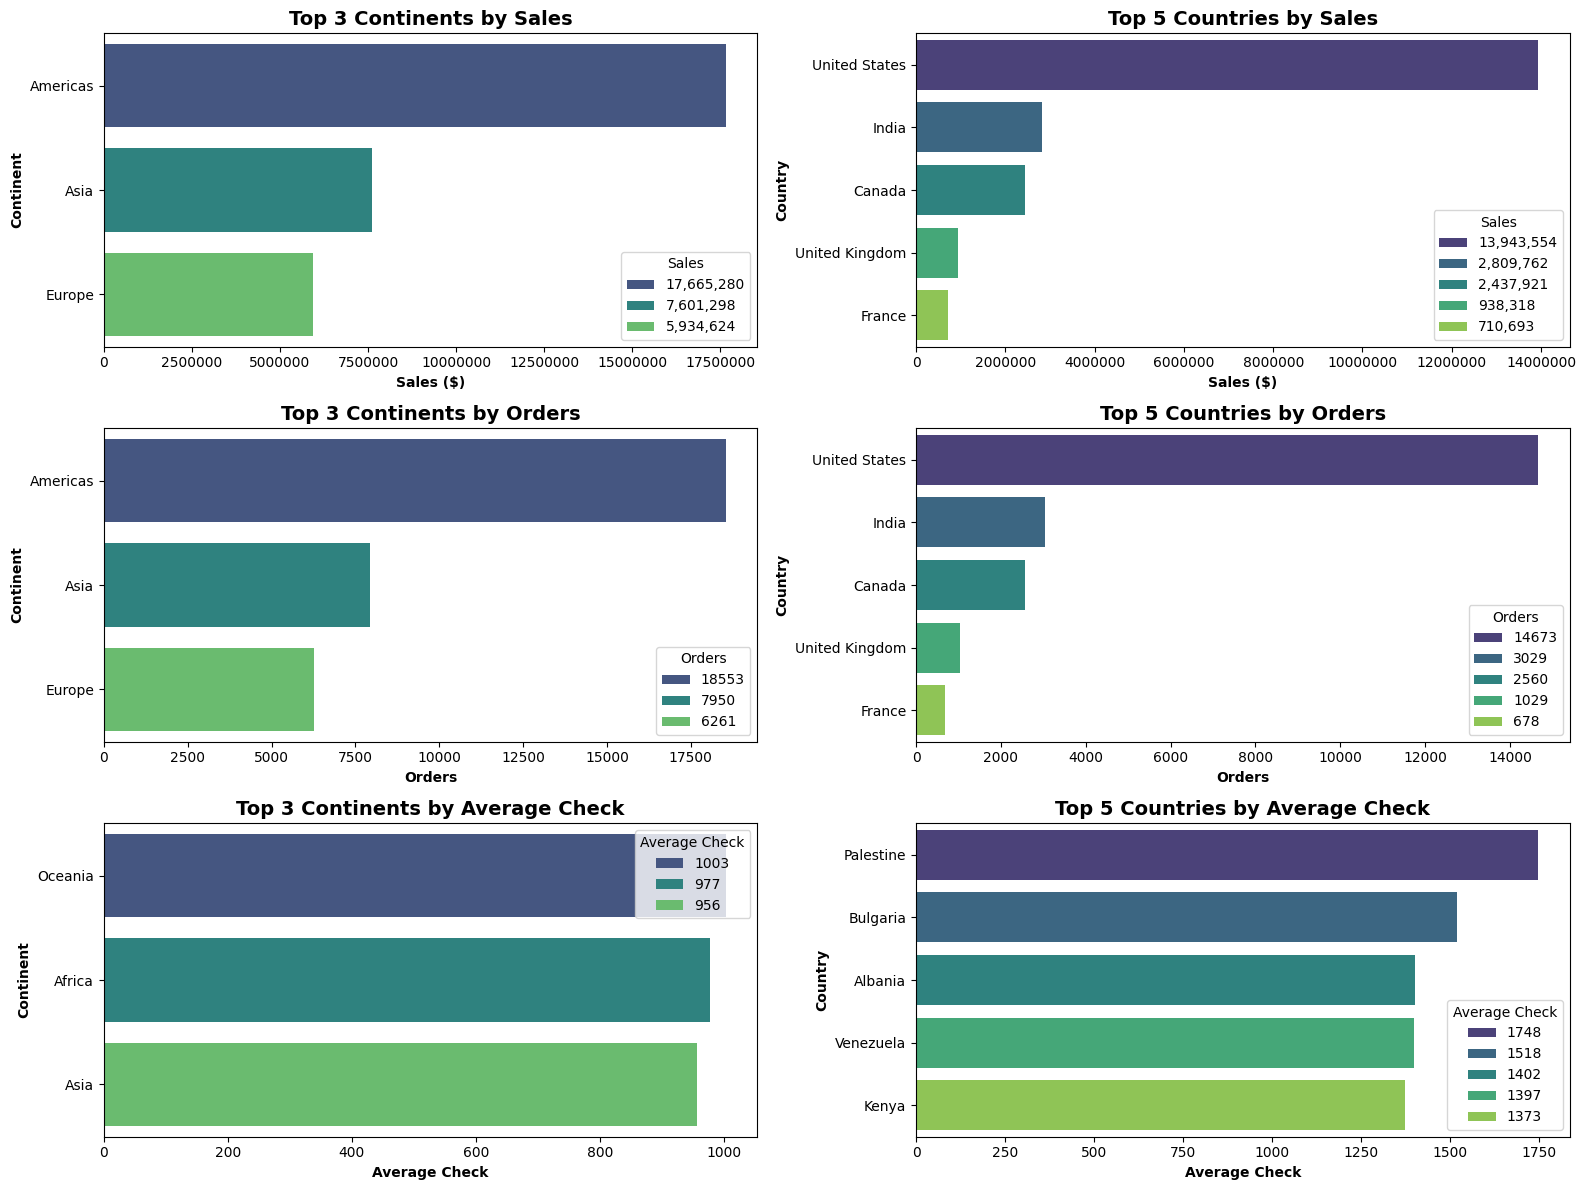

In [ ]:
# Top-3 continents and top-5 countries by sales, orders and average check
fig, ax = plt.subplots(3, 2, figsize=(16, 12))

sns.barplot(
    data=by_continent.nlargest(3, "sales"),
    x="sales", y="continent", hue="sales",
    palette=sns.color_palette("viridis_r", n_colors=3), ax=ax[0,0]
)
ax[0, 0].set_title("Top 3 Continents by Sales", fontsize=14, fontweight='bold')
ax[0, 0].set_xlabel("Sales ($)", fontsize=10, fontweight='bold')
ax[0, 0].set_ylabel("Continent", fontsize=10, fontweight='bold')
ax[0, 0].ticklabel_format(style='plain', axis='x')

handles, labels = ax[0, 0].get_legend_handles_labels()
labels = [float(lbl) for lbl in labels]
sorted_pairs = sorted(zip(labels, handles), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_pairs)
sorted_labels = [f"{lbl:,.0f}" for lbl in sorted_labels]
ax[0, 0].legend(sorted_handles, sorted_labels, title="Sales")

sns.barplot(
    data= by_continent.nlargest(3, "orders"),
    x="orders", y="continent", hue="orders",
    palette=sns.color_palette("viridis_r", n_colors=3), ax=ax[1,0]
)
ax[1, 0].set_title("Top 3 Continents by Orders", fontsize=14, fontweight='bold')
ax[1, 0].set_xlabel("Orders", fontsize=10, fontweight='bold')
ax[1, 0].set_ylabel("Continent", fontsize=10, fontweight='bold')
ax[1, 0].ticklabel_format(style='plain', axis='x')

handles, labels = ax[1, 0].get_legend_handles_labels()
labels = [float(lbl) for lbl in labels]
sorted_pairs = sorted(zip(labels, handles), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_pairs)
sorted_labels = [f"{lbl:.0f}" for lbl in sorted_labels]
ax[1, 0].legend(sorted_handles, sorted_labels, title="Orders")

sns.barplot(
    data= by_continent[by_continent.index != "(not set)"].nlargest(3, "avg_check"),
    x="avg_check", y="continent", hue="avg_check",
    palette=sns.color_palette("viridis_r", n_colors=3), ax=ax[2,0]
)
ax[2, 0].set_title("Top 3 Continents by Average Check", fontsize=14, fontweight='bold')
ax[2, 0].set_xlabel("Average Check", fontsize=10, fontweight='bold')
ax[2, 0].set_ylabel("Continent", fontsize=10, fontweight='bold')
ax[2, 0].ticklabel_format(style='plain', axis='x')

handles, labels = ax[2, 0].get_legend_handles_labels()
labels = [float(lbl) for lbl in labels]
sorted_pairs = sorted(zip(labels, handles), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_pairs)
sorted_labels = [f"{lbl:.0f}" for lbl in sorted_labels]
ax[2, 0].legend(sorted_handles, sorted_labels, title="Average Check")

sns.barplot(
    data=by_country.nlargest(5, "sales"),
    x="sales", y="country", hue="sales",
    palette=sns.color_palette("viridis_r", n_colors=5), ax=ax[0,1]
)
ax[0, 1].set_title("Top 5 Countries by Sales", fontsize=14, fontweight='bold')
ax[0, 1].set_xlabel("Sales ($)", fontsize=10, fontweight='bold')
ax[0, 1].set_ylabel("Country", fontsize=10, fontweight='bold')
ax[0, 1].ticklabel_format(style='plain', axis='x')

handles, labels = ax[0, 1].get_legend_handles_labels()
labels = [float(lbl) for lbl in labels]
sorted_pairs = sorted(zip(labels, handles), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_pairs)
sorted_labels = [f"{lbl:,.0f}" for lbl in sorted_labels]
ax[0, 1].legend(sorted_handles, sorted_labels, title="Sales")

sns.barplot(
    data=by_country.nlargest(5, "orders"),
    x="orders", y="country", hue="orders",
    palette=sns.color_palette("viridis_r", n_colors=5), ax=ax[1,1]
)
ax[1, 1].set_title("Top 5 Countries by Orders", fontsize=14, fontweight='bold')
ax[1, 1].set_xlabel("Orders", fontsize=10, fontweight='bold')
ax[1, 1].set_ylabel("Country", fontsize=10, fontweight='bold')
ax[1, 1].ticklabel_format(style='plain', axis='x')

handles, labels = ax[1, 1].get_legend_handles_labels()
labels = [float(lbl) for lbl in labels]
sorted_pairs = sorted(zip(labels, handles), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_pairs)
sorted_labels = [f"{lbl:.0f}" for lbl in sorted_labels]
ax[1, 1].legend(sorted_handles, sorted_labels, title="Orders")

sns.barplot(
    data=by_country.nlargest(5, "avg_check"),
    x="avg_check", y="country", hue="avg_check",
    palette=sns.color_palette("viridis_r", n_colors=5), ax=ax[2,1]
)
ax[2, 1].set_title("Top 5 Countries by Average Check", fontsize=14, fontweight='bold')
ax[2, 1].set_xlabel("Average Check", fontsize=10, fontweight='bold')
ax[2, 1].set_ylabel("Country", fontsize=10, fontweight='bold')
ax[2, 1].ticklabel_format(style='plain', axis='x')

handles, labels = ax[2, 1].get_legend_handles_labels()
labels = [float(lbl) for lbl in labels]
sorted_pairs = sorted(zip(labels, handles), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_pairs)
sorted_labels = [f"{lbl:.0f}" for lbl in sorted_labels]
ax[2, 1].legend(sorted_handles, sorted_labels, title="Average Check")

plt.tight_layout()
plt.show()

## Sales by category

In [ ]:
# Sales and orders by category
by_category = pd.pivot_table(
    df,
    values=["price", "product_name"],
    index="category",
    aggfunc={"price": "sum", "product_name": "count"}
    ).rename(columns={"price": "sales", "product_name": "orders"})

print(by_category)

                                          sales  orders
category                                               
Bar furniture                          735503.0    1092
Beds                                  4919725.0    2926
Bookcases & shelving units            3640818.1    7630
Cabinets & cupboards                  2336499.5    2318
Café furniture                         138168.0     359
Chairs                                6147748.8    5952
Chests of drawers & drawer units       906562.5    1452
Children's furniture                   467697.0    1702
Nursery furniture                      141607.0     394
Outdoor furniture                     2142222.2    2229
Room dividers                           90288.0     110
Sideboards, buffets & console tables   126330.0     132
Sofas & armchairs                     8388254.5    4301
Tables & desks                        1790307.5    2941


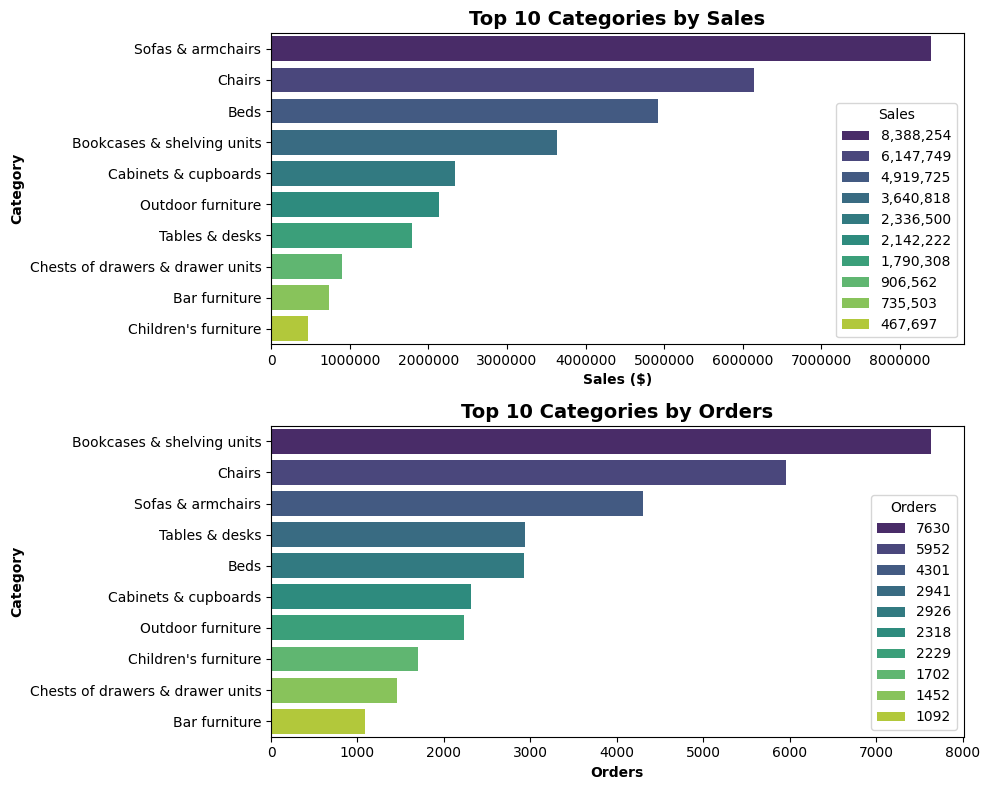

In [ ]:
# Top-10 categories by sales and orders
fig, ax = plt.subplots(2, figsize=(10, 8))

sns.barplot(
    data=by_category.nlargest(10, "sales"),
    x="sales", y="category", hue="sales",
    palette=sns.color_palette("viridis_r", n_colors=10), ax=ax[0]
)
ax[0].set_title("Top 10 Categories by Sales", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Sales ($)", fontsize=10, fontweight='bold')
ax[0].set_ylabel("Category", fontsize=10, fontweight='bold')
ax[0].ticklabel_format(style='plain', axis='x')

handles, labels = ax[0].get_legend_handles_labels()
labels = [float(lbl) for lbl in labels]
sorted_pairs = sorted(zip(labels, handles), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_pairs)
sorted_labels = [f"{lbl:,.0f}" for lbl in sorted_labels]
ax[0].legend(sorted_handles, sorted_labels, title="Sales")

sns.barplot(
    data=by_category.nlargest(10, "orders"),
    x="orders", y="category", hue="orders",
    palette=sns.color_palette("viridis_r", n_colors=10), ax=ax[1]
)
ax[1].set_title("Top 10 Categories by Orders", fontsize=14, fontweight='bold')
ax[1].set_xlabel("Orders", fontsize=10, fontweight='bold')
ax[1].set_ylabel("Category", fontsize=10, fontweight='bold')
ax[1].ticklabel_format(style='plain', axis='x')

handles, labels = ax[1].get_legend_handles_labels()
labels = [float(lbl) for lbl in labels]
sorted_pairs = sorted(zip(labels, handles), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_pairs)
sorted_labels = [f"{lbl:.0f}" for lbl in sorted_labels]
ax[1].legend(sorted_handles, sorted_labels, title="Orders")

plt.tight_layout()
plt.show()

In [ ]:
# MAX and MIN price by category
price_by_category = pd.pivot_table(
    df,
    values=["price"],
    index="category",
    aggfunc=["max", "min"]
    )
print(price_by_category)

                                         max    min
                                       price  price
category                                           
Bar furniture                         2375.0   40.0
Beds                                  9585.0   30.0
Bookcases & shelving units            4335.0    3.0
Cabinets & cupboards                  6480.0   22.0
Café furniture                        1140.0  145.0
Chairs                                6965.0   11.4
Chests of drawers & drawer units      1880.0   49.0
Children's furniture                  1545.0    5.0
Nursery furniture                     1225.0   25.0
Outdoor furniture                     5144.0    9.0
Room dividers                         2397.0  189.0
Sideboards, buffets & console tables  1950.0  295.0
Sofas & armchairs                     9585.0   27.0
Tables & desks                        6614.0    9.0


## Sales by category and geography

In [ ]:
# Category with max sales and orders by country
data_grouped_by_countries = (df.groupby(["country", "category"])
                 .agg({"price": "sum", "product_name": "count"})
                ).rename(columns={"price": "sales", "product_name": "orders"})

category_with_max_sales = data_grouped_by_countries.groupby("country")["sales"].idxmax()
max_sales = data_grouped_by_countries.loc[category_with_max_sales, "sales"]

category_with_max_orders = data_grouped_by_countries.groupby("country")["orders"].idxmax()
max_orders = data_grouped_by_countries.loc[category_with_max_orders, "orders"]

result = pd.DataFrame({
    "max_sales_category": [cat for country, cat in category_with_max_sales],
    "max_sales": max_sales.values,
    "max_orders_category": [cat for country, cat in category_with_max_orders],
    "max_orders": max_orders.values
}, index=category_with_max_sales.index)

display(result)


max_sales_category  max_sales         max_orders_category  \
country                                                                       
(not set)                     Chairs    74130.0                      Chairs   
Albania            Sofas & armchairs     6490.0                      Chairs   
Algeria            Sofas & armchairs    17056.0                        Beds   
Argentina          Sofas & armchairs    38046.0  Bookcases & shelving units   
Armenia            Outdoor furniture     2616.4                      Chairs   
...                              ...        ...                         ...   
United Kingdom     Sofas & armchairs   234812.0  Bookcases & shelving units   
United States      Sofas & armchairs  3707144.5  Bookcases & shelving units   
Uruguay         Cabinets & cupboards     7223.0  Bookcases & shelving units   
Venezuela                     Chairs     6954.0  Bookcases & shelving units   
Vietnam                         Beds    26506.0  Bookcases & shelving units   

                max_orders  
country                     
(not set)               64  
Albania                  3  
Algeria                  5  
Argentina               18  
Armenia                  5  
...                    ...  
United Kingdom         232  
United States         3374  
Uruguay                  3  
Venezuela                5  
Vietnam                 32  

[108 rows x 4 columns]

In [ ]:
# Sales by country and category
by_country_and_category = pd.pivot_table(
    df,
    values="price",
    index="country",
    columns="category",
    aggfunc="sum"
).rename(columns={"price": "sales"})

display(by_country_and_category)

category        Bar furniture       Beds  Bookcases & shelving units  \
country                                                                
(not set)              5156.0    38094.0                     24991.0   
Albania                 595.0        NaN                      1385.0   
Algeria                   NaN     3830.0                       380.0   
Argentina              3447.0     1462.0                      7372.0   
Armenia                   NaN        NaN                         NaN   
...                       ...        ...                         ...   
United Kingdom        22103.0   133816.0                    113987.6   
United States        330805.0  2213058.0                   1567606.9   
Uruguay                 298.0        NaN                      1737.0   
Venezuela                 NaN     5840.0                      1007.0   
Vietnam                4523.0    26506.0                     18409.6   

category        Cabinets & cupboards  Café furniture     Chairs  \
country                                                           
(not set)                    16024.0          1549.0    74130.0   
Albania                          NaN             NaN     4365.0   
Algeria                          NaN             NaN     1630.0   
Argentina                    10472.0           871.0    10325.4   
Armenia                        302.0             NaN     2495.0   
...                              ...             ...        ...   
United Kingdom               71684.5          4554.0   188519.4   
United States               994545.5         59000.0  2619773.8   
Uruguay                       7223.0             NaN        NaN   
Venezuela                     1350.0             NaN     6954.0   
Vietnam                       9354.0           395.0    22089.0   

category        Chests of drawers & drawer units  Children's furniture  \
country                                                                  
(not set)                                 7021.5                1755.0   
Albania                                      NaN                   NaN   
Algeria                                    139.0                   NaN   
Argentina                                 2945.0                1274.0   
Armenia                                      NaN                   NaN   
...                                          ...                   ...   
United Kingdom                           36784.0               13348.0   
United States                           382388.0              207575.0   
Uruguay                                      NaN                  74.0   
Venezuela                                  175.0                   NaN   
Vietnam                                   1374.0                3108.0   

category        Nursery furniture  Outdoor furniture  Room dividers  \
country                                                               
(not set)                  1120.0            16694.8         2397.0   
Albania                       NaN                NaN            NaN   
Algeria                       NaN              251.0            NaN   
Argentina                     NaN             8393.4          715.0   
Armenia                       NaN             2616.4            NaN   
...                           ...                ...            ...   
United Kingdom             2775.0            57002.4         5458.0   
United States             65998.0           929245.2        30439.0   
Uruguay                       NaN                NaN            NaN   
Venezuela                     NaN             2832.0            NaN   
Vietnam                    1194.0             5474.0         2377.0   

category        Sideboards, buffets & console tables  Sofas & armchairs  \
country                                                                   
(not set)                                        NaN            56230.0   
Albania                                          NaN             6490.0   
Alge

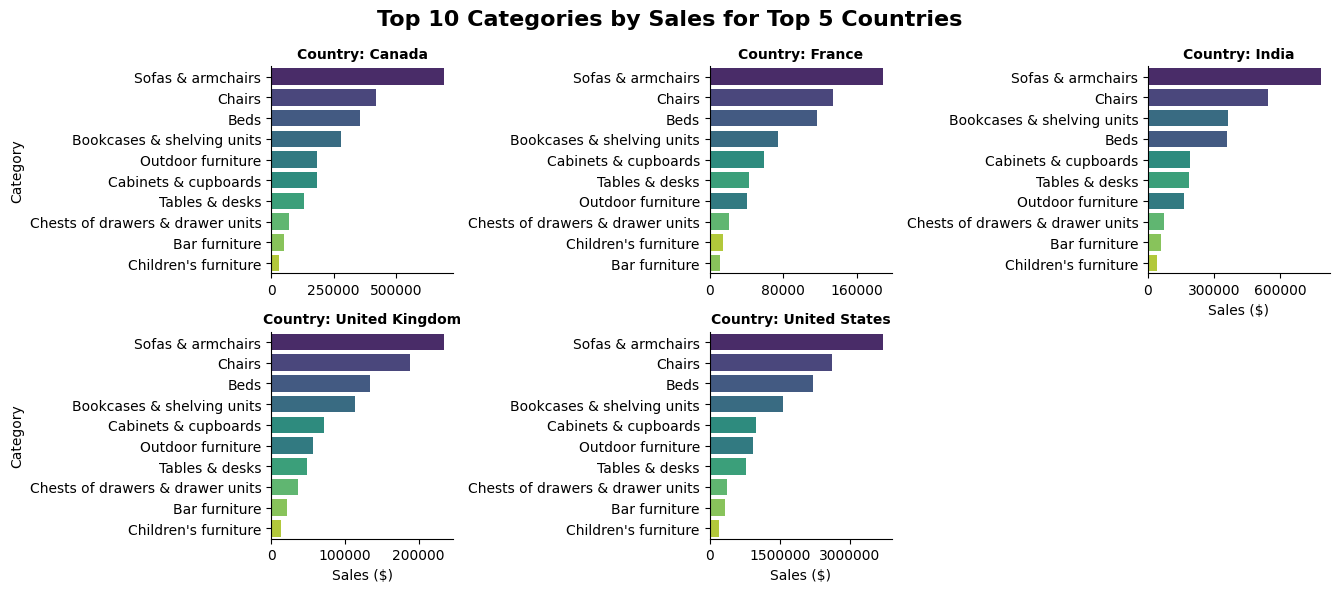

In [ ]:
# Top 10 categories by sales for top 5 countries
top5_countries_by_sales = by_country.nlargest(5, "sales").reset_index()["country"]
data_filtered = data_grouped_by_countries.reset_index()[data_grouped_by_countries.reset_index()["country"]
                                                        .isin(top5_countries_by_sales)]
top10_by_sales_for_top5_countries = (
    data_filtered
    .sort_values(["country", "sales"], ascending=[True, False])
    .groupby("country")
    .head(10)
)

g = sns.catplot(
    data=top10_by_sales_for_top5_countries,
    x="sales",
    y="category",
    col="country",
    col_wrap=3,
    kind="bar",
    height=3,
    aspect=1.5,
    sharex=False,
    sharey=False,
    hue="category",
    palette=sns.color_palette("viridis", n_colors=10)
)

g.fig.suptitle("Top 10 Categories by Sales for Top 5 Countries", fontsize=16, fontweight='bold')
g.set_titles("Country: {col_name}", fontweight='bold')
g.set_axis_labels("Sales ($)", "Category")

for ax_sub in g.axes.flat:
    ax_sub.ticklabel_format(style='plain', axis='x')
    ax_sub.xaxis.set_major_locator(plt.MaxNLocator(nbins=3))

plt.tight_layout()
plt.show()

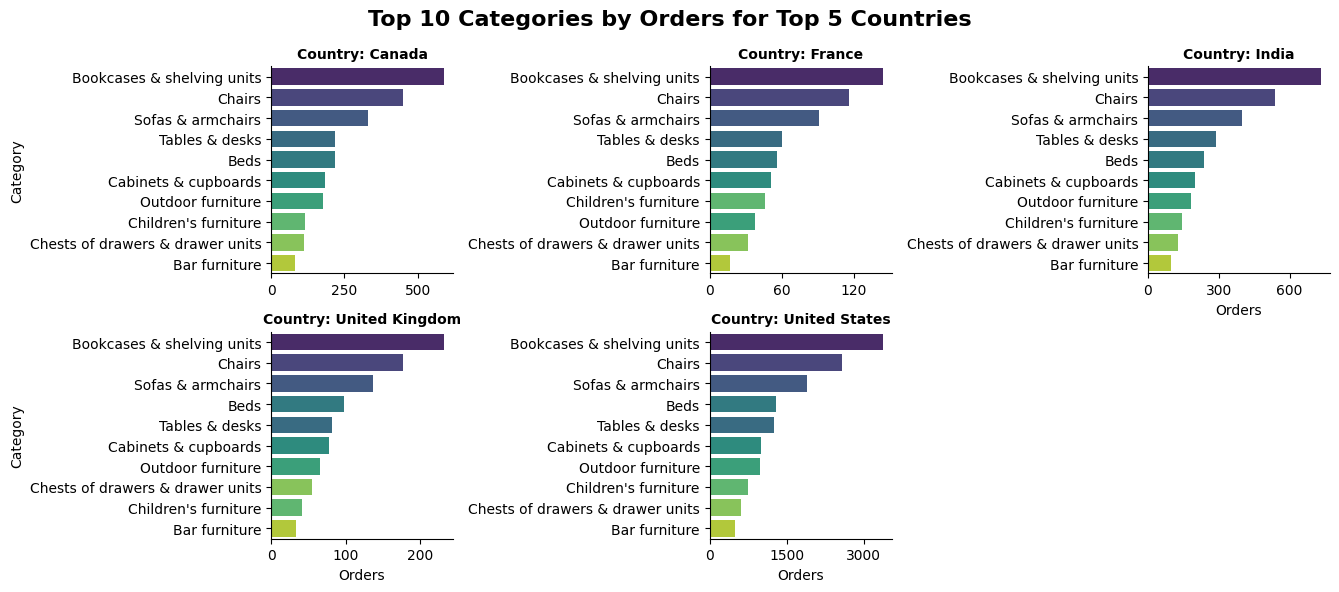

In [ ]:
# Top 10 categories by orders for top 5 countries
top10_by_orders_for_top5_countries = (
    data_filtered
    .sort_values(["country", "orders"], ascending=[True, False])
    .groupby("country")
    .head(10)
)

g = sns.catplot(
    data=top10_by_orders_for_top5_countries,
    x="orders",
    y="category",
    col="country",
    col_wrap=3,
    kind="bar",
    height=3,
    aspect=1.5,
    sharex=False,
    sharey=False,
    hue="category",
    palette=sns.color_palette("viridis", n_colors=10)
)

g.fig.suptitle("Top 10 Categories by Orders for Top 5 Countries", fontsize=16, fontweight='bold')
g.set_titles("Country: {col_name}", fontweight='bold')
g.set_axis_labels("Orders", "Category")

for ax_sub in g.axes.flat:
    ax_sub.ticklabel_format(style='plain', axis='x')
    ax_sub.xaxis.set_major_locator(plt.MaxNLocator(nbins=3))

plt.tight_layout()
plt.show()

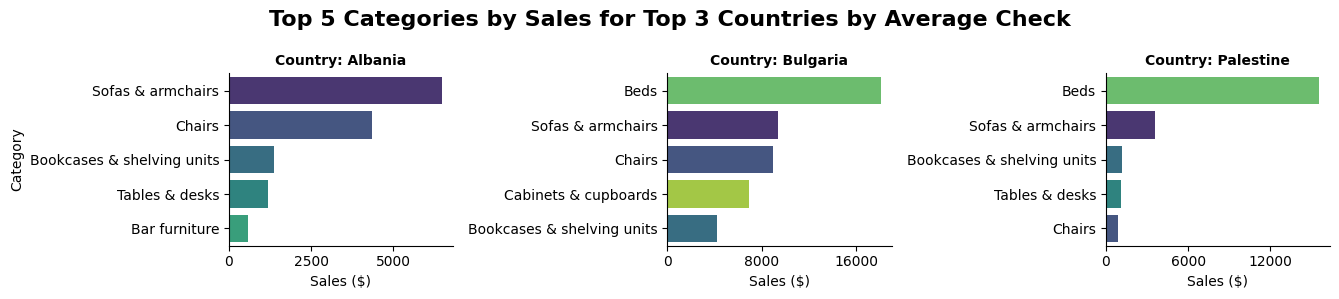

In [ ]:
# Top 5 categories by sales for top 3 countries by average check
top3_countries_by_avg_check = by_country.nlargest(3, "avg_check").reset_index()["country"]
data_filtered_1 = data_grouped_by_countries.reset_index()[data_grouped_by_countries.reset_index()["country"]
                                                        .isin(top3_countries_by_avg_check)]
top5_by_sales_for_top3_countries_by_avg_check = (
    data_filtered_1
    .sort_values(["country", "sales"], ascending=[True, False])
    .groupby("country")
    .head(5)
)

g = sns.catplot(
    data=top5_by_sales_for_top3_countries_by_avg_check,
    x="sales",
    y="category",
    col="country",
    col_wrap=3,
    kind="bar",
    height=3,
    aspect=1.5,
    sharex=False,
    sharey=False,
    hue="category",
    palette=sns.color_palette("viridis", n_colors=top5_by_sales_for_top3_countries_by_avg_check["category"].nunique())
)

g.fig.suptitle("Top 5 Categories by Sales for Top 3 Countries by Average Check", fontsize=16, fontweight='bold')
g.set_titles("Country: {col_name}", fontweight='bold')
g.set_axis_labels("Sales ($)", "Category")

for ax_sub in g.axes.flat:
    ax_sub.ticklabel_format(style='plain', axis='x')
    ax_sub.xaxis.set_major_locator(plt.MaxNLocator(nbins=3))

plt.tight_layout()
plt.show()

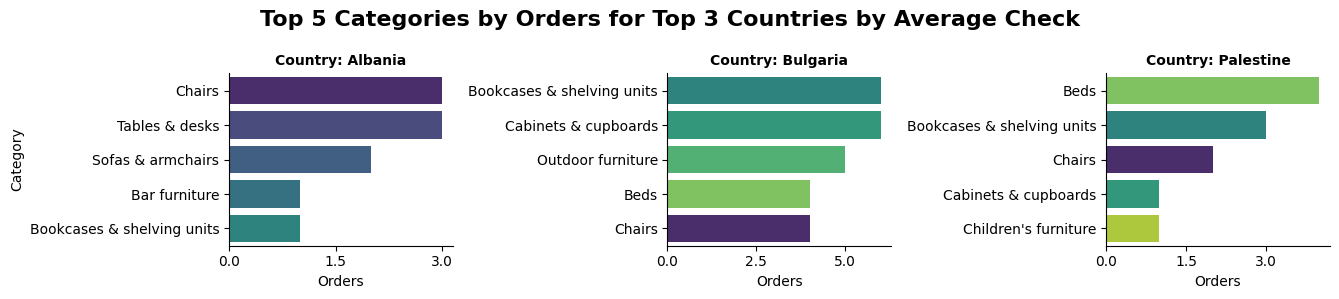

In [ ]:
# Top 5 categories by orders for top 3 countries by average check
top5_by_orders_for_top3_countries_by_avg_check = (
    data_filtered_1
    .sort_values(["country", "orders"], ascending=[True, False])
    .groupby("country")
    .head(5)
)

g = sns.catplot(
    data=top5_by_orders_for_top3_countries_by_avg_check,
    x="orders",
    y="category",
    col="country",
    col_wrap=3,
    kind="bar",
    height=3,
    aspect=1.5,
    sharex=False,
    sharey=False,
    hue="category",
    palette=sns.color_palette("viridis", n_colors=top5_by_orders_for_top3_countries_by_avg_check["category"].nunique())
)

g.fig.suptitle("Top 5 Categories by Orders for Top 3 Countries by Average Check", fontsize=16, fontweight='bold')
g.set_titles("Country: {col_name}", fontweight='bold')
g.set_axis_labels("Orders", "Category")

for ax_sub in g.axes.flat:
    ax_sub.ticklabel_format(style='plain', axis='x')
    ax_sub.xaxis.set_major_locator(plt.MaxNLocator(nbins=3))

plt.tight_layout()
plt.show()


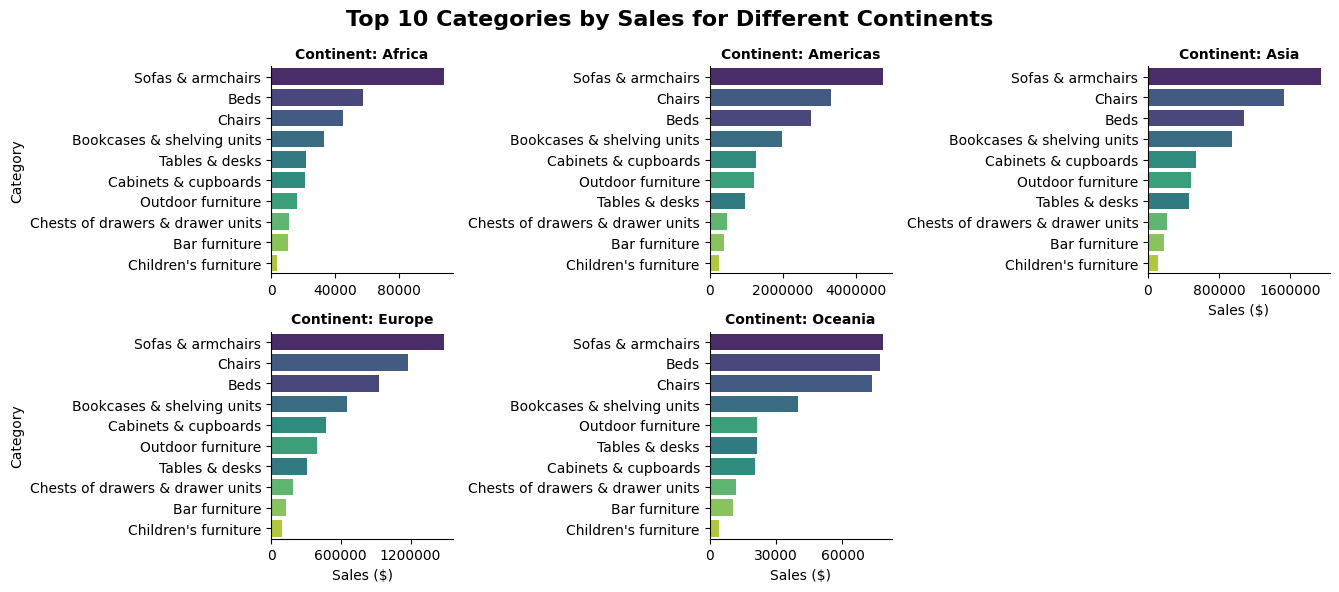

In [ ]:
# Top 10 categories by sales for different continents
data_grouped_by_continent = (df.groupby(["continent", "category"]).agg({"price": "sum", "product_name": "count"})
                ).rename(columns={"price": "sales", "product_name": "orders"})
top10_by_sales_for_continents = (
    data_grouped_by_continent
    .reset_index()
    .sort_values(["continent", "sales"], ascending=[True, False])
    .groupby("continent")
    .head(10)
)

g = sns.catplot(
    data=top10_by_sales_for_continents[top10_by_sales_for_continents["continent"] != "(not set)"],
    x="sales",
    y="category",
    col="continent",
    col_wrap=3,
    kind="bar",
    height=3,
    aspect=1.5,
    sharex=False,
    sharey=False,
    hue="category",
    palette=sns.color_palette("viridis", n_colors=10)
)

g.fig.suptitle("Top 10 Categories by Sales for Different Continents", fontsize=16, fontweight='bold')
g.set_titles("Continent: {col_name}", fontweight='bold')
g.set_axis_labels("Sales ($)", "Category")

for ax_sub in g.axes.flat:
    ax_sub.ticklabel_format(style='plain', axis='x')
    ax_sub.xaxis.set_major_locator(plt.MaxNLocator(nbins=3))

plt.tight_layout()
plt.show()

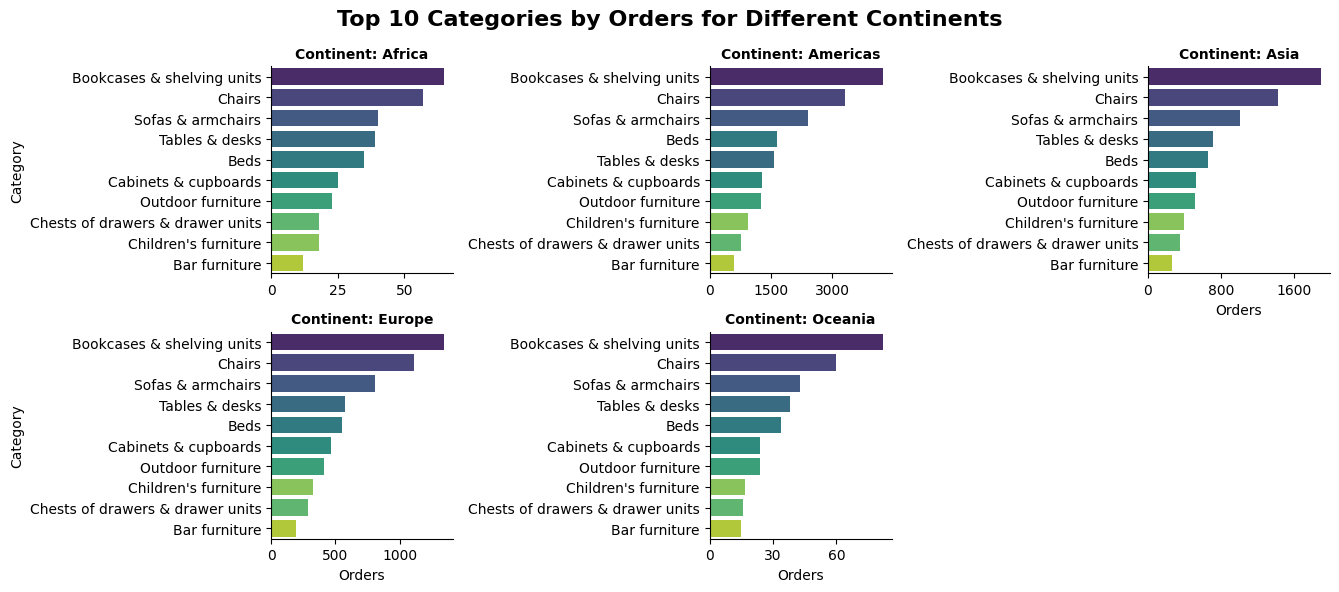

In [ ]:
# Top 10 categories by orders for different continents
top10_by_orders_for_continents = (
    data_grouped_by_continent
    .reset_index()
    .sort_values(["continent", "orders"], ascending=[True, False])
    .groupby("continent")
    .head(10)
)

g = sns.catplot(
    data=top10_by_orders_for_continents[top10_by_orders_for_continents["continent"] != "(not set)"],
    x="orders",
    y="category",
    col="continent",
    col_wrap=3,
    kind="bar",
    height=3,
    aspect=1.5,
    sharex=False,
    sharey=False,
    hue="category",
    palette=sns.color_palette("viridis", n_colors=10)
)

g.fig.suptitle("Top 10 Categories by Orders for Different Continents", fontsize=16, fontweight='bold')
g.set_titles("Continent: {col_name}", fontweight='bold')
g.set_axis_labels("Orders", "Category")

for ax_sub in g.axes.flat:
    ax_sub.ticklabel_format(style='plain', axis='x')
    ax_sub.xaxis.set_major_locator(plt.MaxNLocator(nbins=3))

plt.tight_layout()
plt.show()

## Sales by session parameters

In [ ]:
# Sales by device type
by_device_type = pd.pivot_table(
    df,
    values=["price", "product_name"],
    index="device",
    aggfunc={"price": "sum", "product_name": "count"}
    ).rename(columns={"price": "sales", "product_name": "orders"})

by_device_type["sales_%_from_total"] = by_device_type["sales"] / by_device_type["sales"].sum() * 100
by_device_type["orders_%_from_total"] = by_device_type["orders"] / by_device_type["orders"].sum() * 100

print(by_device_type)

              sales  orders  sales_%_from_total  orders_%_from_total
device                                                              
desktop  18864039.0   19702           59.002245            58.745304
mobile   12384225.8   13113           38.734924            39.098933
tablet     723466.3     723            2.262831             2.155764


In [ ]:
# Sales by device model
by_device_model = pd.pivot_table(
    df,
    values=["price", "product_name"],
    index="mobile_model_name",
    aggfunc={"price": "sum", "product_name": "count"}
    ).rename(columns={"price": "sales", "product_name": "orders"})

by_device_model["sales_%_from_total"] = by_device_model["sales"] / by_device_model["sales"].sum() * 100
by_device_model["orders_%_from_total"] = by_device_model["orders"] / by_device_model["orders"].sum() * 100

print(by_device_model)

                       sales  orders  sales_%_from_total  orders_%_from_total
mobile_model_name                                                            
<Other>            6535330.8    6801           20.440966            20.278490
Chrome             8899523.9    9359           27.835602            27.905659
ChromeBook         1830458.7    1877            5.725241             5.596637
Edge                697222.3     741            2.180746             2.209434
Firefox             421066.9     430            1.316998             1.282128
Pixel 3             109148.2     105            0.341390             0.313078
Pixel 4 XL          118287.7     117            0.369976             0.348858
Safari             6491062.1    6833           20.302504            20.373904
iPad                448854.2     456            1.403910             1.359652
iPhone             6420776.3    6819           20.082667            20.332161


In [ ]:
# Adding values ​​< 1% to <Other>
by_device_model_1 = by_device_model.reset_index()
by_device_model_1.loc[by_device_model_1["sales_%_from_total"] < 1, "mobile_model_name"] = "<Other>"

by_device_model_grouped = by_device_model_1.groupby("mobile_model_name", as_index=True)[
    ["sales_%_from_total", "orders_%_from_total"]
    ].sum()

In [ ]:
# Sales by operating system
by_operating_system = pd.pivot_table(
    df,
    values=["price", "product_name"],
    index="operating_system",
    aggfunc={"price": "sum", "product_name": "count"}
    ).rename(columns={"price": "sales", "product_name": "orders"})

by_operating_system["sales_%_from_total"] = by_operating_system["sales"] / by_operating_system["sales"].sum() * 100
by_operating_system["orders_%_from_total"] = by_operating_system["orders"] / by_operating_system["orders"].sum() * 100

print(by_operating_system)

                       sales  orders  sales_%_from_total  orders_%_from_total
operating_system                                                             
<Other>             822555.8     882            2.572760             2.629853
Android            2789985.1    2852            8.726412             8.503787
Macintosh          2504967.3    2573            7.834944             7.671895
Web               18445904.5   19537           57.694419            58.253325
Windows            3804989.0    3896           11.901104            11.616674
iOS                3603329.4    3798           11.270361            11.324468


In [ ]:
# Sales by browser
by_browser = pd.pivot_table(
    df,
    values=["price", "product_name"],
    index="browser",
    aggfunc={"price": "sum", "product_name": "count"}
    ).rename(columns={"price": "sales", "product_name": "orders"})

by_browser["sales_%_from_total"] = by_browser["sales"] / by_browser["sales"].sum() * 100
by_browser["orders_%_from_total"] = by_browser["orders"] / by_browser["orders"].sum() * 100

print(by_browser)

                      sales  orders  sales_%_from_total  orders_%_from_total
browser                                                                     
<Other>            923354.8     865            2.888035             2.579164
Android Webview    411014.4     420            1.285556             1.252311
Chrome           21826850.0   23015           68.269215            68.623651
Edge               716444.3     752            2.240868             2.242233
Firefox            567523.6     583            1.775079             1.738327
Safari            7526544.0    7903           23.541246            23.564315


In [ ]:
# Sales by traffic source
by_traffic_source = pd.pivot_table(
    df,
    values=["price", "product_name"],
    index="traffic_source",
    aggfunc={"price": "sum", "product_name": "count"}
    ).rename(columns={"price": "sales", "product_name": "orders"})

by_traffic_source["sales_%_from_total"] = by_traffic_source["sales"] / by_traffic_source["sales"].sum() * 100
by_traffic_source["orders_%_from_total"] = by_traffic_source["orders"] / by_traffic_source["orders"].sum() * 100

print(by_traffic_source)

                     sales  orders  sales_%_from_total  orders_%_from_total
traffic_source                                                             
(data deleted)   2002337.0    2055            6.262836             6.127378
(direct)         7494923.4    7800           23.442345            23.257201
(organic)       10935239.9   11430           34.202840            34.080744
(referral)       5641855.2    6001           17.646386            17.893136
<Other>          5897375.6    6252           18.445594            18.641541


In [ ]:
# Sales by channel
by_channel = pd.pivot_table(
    df,
    values=["price", "product_name"],
    index="channel",
    aggfunc={"price": "sum", "product_name": "count"}
    ).rename(columns={"price": "sales", "product_name": "orders"})

by_channel["sales_%_from_total"] = by_channel["sales"] / by_channel["sales"].sum() * 100
by_channel["orders_%_from_total"] = by_channel["orders"] / by_channel["orders"].sum() * 100

print(by_channel)

                     sales  orders  sales_%_from_total  orders_%_from_total
channel                                                                    
Direct           7494923.4    7800           23.442345            23.257201
Organic Search  11433151.6   11921           35.760189            35.544755
Paid Search      8511049.4    9042           26.620546            26.960463
Social Search    2532105.7    2716            7.919827             8.098277
Undefined        2000501.0    2059            6.257093             6.139305


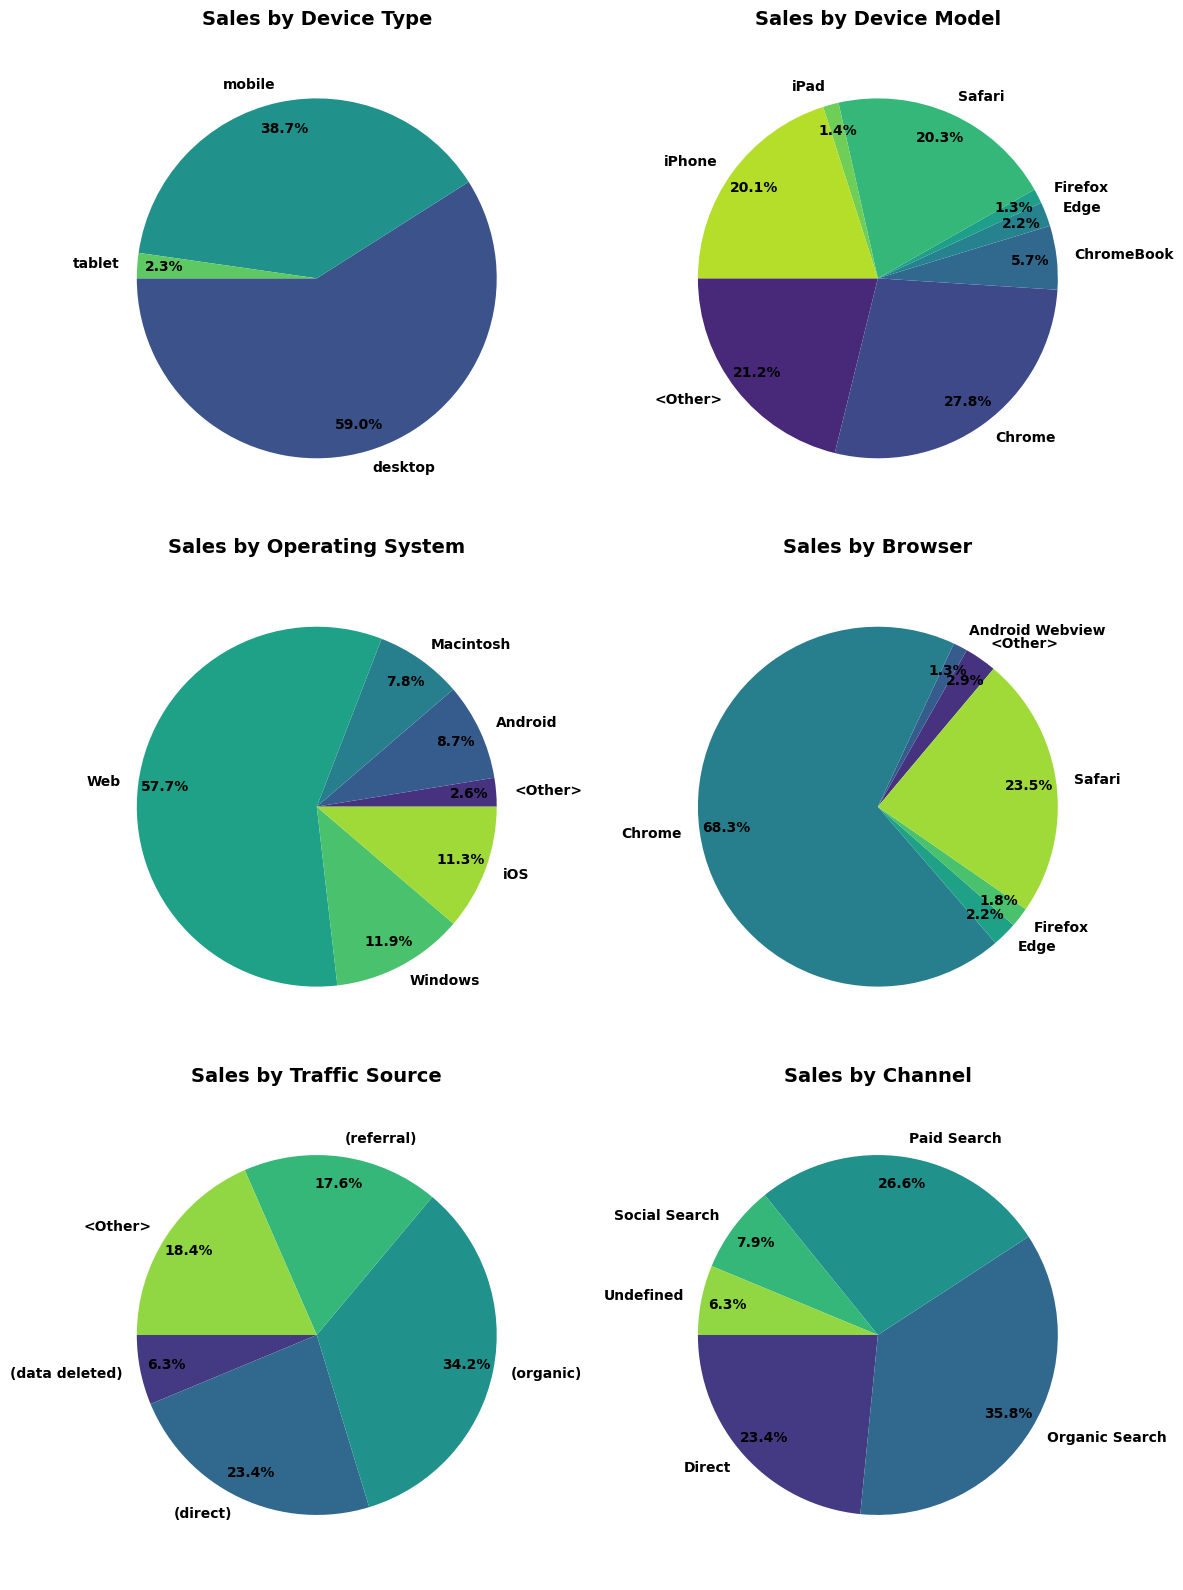

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 16))

ax[0, 0].pie(by_device_type["sales"], labels=by_device_type.index,
             autopct='%1.1f%%', startangle=180, pctdistance=0.85,
             colors=sns.color_palette("viridis", len(by_device_type)),
             textprops={'fontweight': 'bold'})
ax[0, 0].set_title("Sales by Device Type", fontsize=14, fontweight='bold')
ax[0, 0].axis('equal')

ax[0, 1].pie(by_device_model_grouped["sales_%_from_total"], labels=by_device_model_grouped.index,
             autopct='%1.1f%%', startangle=180, pctdistance=0.85,
             colors=sns.color_palette("viridis", len(by_device_model_grouped)),
             textprops={'fontweight': 'bold'})
ax[0, 1].set_title("Sales by Device Model", fontsize=14, fontweight='bold')
ax[0, 1].axis('equal')

ax[1, 0].pie(by_operating_system["sales"], labels=by_operating_system.index,
             autopct='%1.1f%%', pctdistance=0.85,
             colors=sns.color_palette("viridis", len(by_operating_system)),
             textprops={'fontweight': 'bold'})
ax[1, 0].set_title("Sales by Operating System", fontsize=14, fontweight='bold')
ax[1, 0].axis('equal')

ax[1, 1].pie(by_browser["sales"], labels=by_browser.index,
             autopct='%1.1f%%', startangle=50, pctdistance=0.85,
             colors=sns.color_palette("viridis", len(by_browser)),
             textprops={'fontweight': 'bold'})
ax[1, 1].set_title("Sales by Browser", fontsize=14, fontweight='bold')
ax[1, 1].axis('equal')

ax[2, 0].pie(by_traffic_source["sales"], labels=by_traffic_source.index,
             autopct='%1.1f%%', startangle=180, pctdistance=0.85,
             colors=sns.color_palette("viridis", len(by_traffic_source)),
             textprops={'fontweight': 'bold'})
ax[2, 0].set_title("Sales by Traffic Source", fontsize=14, fontweight='bold')
ax[2, 0].axis('equal')

ax[2, 1].pie(by_channel["sales"], labels=by_channel.index,
             autopct='%1.1f%%', startangle=180, pctdistance=0.85,
             colors=sns.color_palette("viridis", len(by_channel)),
             textprops={'fontweight': 'bold'})
ax[2, 1].set_title("Sales by Channel", fontsize=14, fontweight='bold')
ax[2, 1].axis('equal')

plt.tight_layout()
plt.show()

In [ ]:
# Sales by language
by_language = pd.pivot_table(
    df,
    values=["price", "product_name"],
    index="language",
    aggfunc={"price": "sum", "product_name": "count"}
    ).rename(columns={'price': 'sales', 'product_name': 'orders'})

by_language["sales_%_from_total"] = by_language["sales"] / by_language["sales"].sum() * 100
by_language["orders_%_from_total"] = by_language["orders"] / by_language["orders"].sum() * 100

print(by_language)

               sales  orders  sales_%_from_total  orders_%_from_total
language                                                             
Unknown   10597901.4   11007           33.147725            32.819488
de          257088.7     304            0.804113             0.906434
en          995536.9    1098            3.113804             3.273898
en-ca       778852.6     891            2.436066             2.656688
en-gb      2181314.3    2344            6.822634             6.989087
en-us     14715870.2   15311           46.027755            45.652692
es-es       514573.1     550            1.609463             1.639931
fr          579024.5     557            1.811051             1.660803
ko          298528.8     272            0.933727             0.811020
zh         1053040.6    1204            3.293662             3.589958


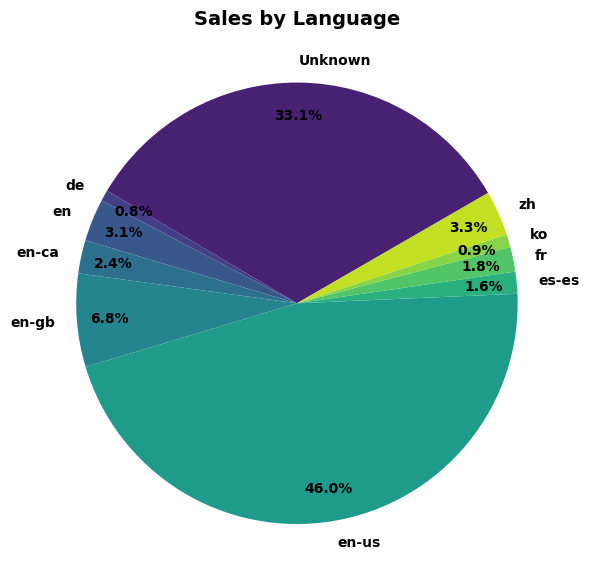

In [ ]:
plt.figure(figsize=(6, 6))

colors = sns.color_palette("viridis", len(by_language))

plt.pie(by_language["sales"], labels=by_language.index,
        autopct='%1.1f%%', startangle=30, pctdistance=0.85,
        colors=colors, textprops={'fontweight': 'bold'})
plt.title("Sales by Language", fontsize=14, fontweight='bold')
plt.axis('equal')

plt.tight_layout()
plt.show()

## Sales by accounts

In [ ]:
# Sales and orders by registration status
df["is_registered"] = df["account_id"].notna().astype(int)

by_registered = pd.pivot_table(
    df,
    values=["price", "product_name"],
    index="is_registered",
    aggfunc={"price": "sum", "product_name": "count"}
    ).rename(index={0: "is_unregistered", 1: "is_registered"}, columns={'price': 'sales', 'product_name': 'orders'}
             ).reset_index(names="registration_status")

print(by_registered)

  registration_status       sales  orders
0     is_unregistered  29389212.6   30757
1       is_registered   2582518.5    2781


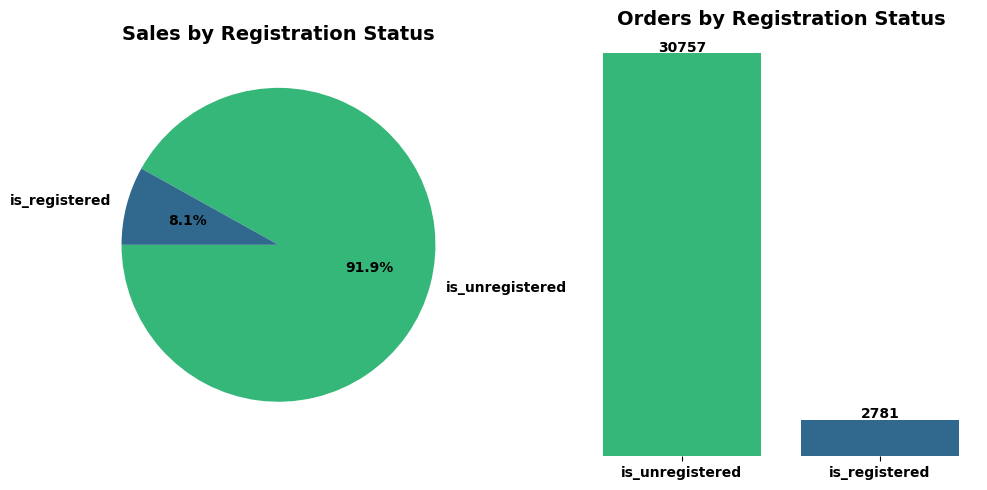

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

colors = sns.color_palette("viridis_r", 2)

ax[0].pie(by_registered["sales"], labels=by_registered["registration_status"],
          autopct='%1.1f%%', startangle=180,
          colors=colors, textprops={'fontweight': 'bold'})
ax[0].set_title("Sales by Registration Status", fontsize=14, fontweight='bold')

bars = ax[1].bar(by_registered["registration_status"], by_registered["orders"], color=colors)
ax[1].set_title("Orders by Registration Status", fontsize=14, fontweight='bold')
ax[1].set_xticks(range(len(by_registered["registration_status"])))
ax[1].set_xticklabels(by_registered["registration_status"], fontweight='bold')
ax[1].set_yticklabels([])
ax[1].tick_params(axis='y', left=False)
ax[1].spines[['top', 'right', 'left', 'bottom']].set_visible(False)

for bar in bars:
  ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 100, f'{bar.get_height()}',
             ha='center', va='bottom', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Verified users
accounts = df["account_id"].count()
verified_users = df[df["is_verified"] == 1].shape[0]
verified_percent = verified_users / accounts * 100

print('Total accounts:', accounts)
print('Verified users:', verified_users)
print(f'Percentage of verified users: {round(verified_percent, 2)}%')

#Unsubscribed users
unsubscribed_users = df[df["is_unsubscribed"] == 1].shape[0]
unsubscribed_percent = unsubscribed_users / accounts * 100

print('Unsubscribed users:', unsubscribed_users)
print(f'Percentage of unsubscribed users : {round(unsubscribed_percent, 2)}"%')

Total accounts: 27945
Verified users: 20036
Percentage of verified users: 71.7%
Unsubscribed users: 4735
Percentage of unsubscribed users : 16.94"%


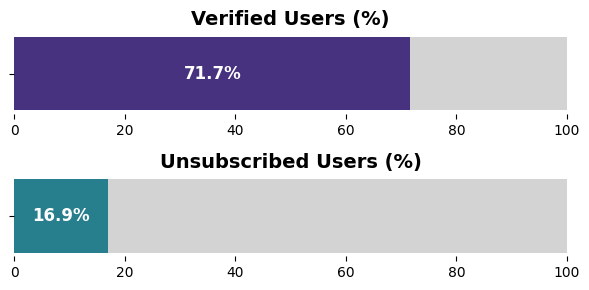

In [ ]:
fig, ax = plt.subplots(2, figsize=(6, 3))

ax[0].barh(["Verified users"], [100], color='lightgray')
ax[0].barh(["Verified users"], [verified_percent], color=sns.color_palette("viridis"))
ax[0].set_xlim(0, 100)
ax[0].text(
    verified_percent/2, 0,
    f"{verified_percent:.1f}%",
    ha='center', va='center',
    color='white', fontsize=12, fontweight='bold'
)
ax[0].set_title("Verified Users (%)", fontsize=14, fontweight='bold')
ax[0].set_yticklabels([])
ax[0].spines[['top', 'right', 'left', 'bottom']].set_visible(False)

ax[1].barh(["Unsubscribed users"], [100], color='lightgray')
ax[1].barh(["Unsubscribed users"], [unsubscribed_percent], color=sns.color_palette("viridis")[2])
ax[1].set_xlim(0, 100)
ax[1].text(
    unsubscribed_percent/2, 0,
    f"{unsubscribed_percent:.1f}%",
    ha='center', va='center',
    color='white', fontsize=12, fontweight='bold'
)
ax[1].set_title("Unsubscribed Users (%)", fontsize=14, fontweight='bold')
ax[1].set_yticklabels([])
ax[1].spines[['top', 'right', 'left', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Sales and orders by subscription_status
by_subs = df.groupby("is_unsubscribed").agg(sales=("price", "sum"), orders=("product_name", "count")
).rename(index={0: "is_subscribed", 1: "is_unsubscribed"}).reset_index(names="subscription_status")

print(by_subs)

  subscription_status      sales  orders
0       is_subscribed  2150796.9    2334
1     is_unsubscribed   431721.6     447


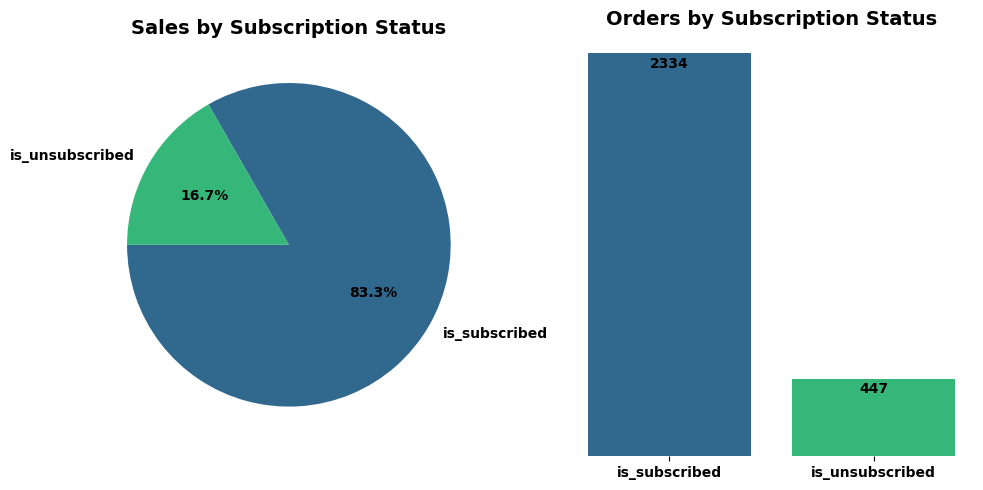

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

colors = sns.color_palette("viridis", 2)

ax[0].pie(by_subs["sales"], labels=by_subs["subscription_status"],
          autopct='%1.1f%%', startangle=180,
          colors=colors, textprops={'fontweight': 'bold'})
ax[0].set_title("Sales by Subscription Status", fontsize=14, fontweight='bold')

bars = ax[1].bar(by_subs["subscription_status"], by_subs["orders"], color=colors)
ax[1].set_title("Orders by Subscription Status", fontsize=14, fontweight='bold')
ax[1].set_xticks(range(len(by_subs["subscription_status"])))
ax[1].set_xticklabels(by_subs["subscription_status"], fontweight='bold')
ax[1].set_yticklabels([])
ax[1].tick_params(axis='y', left=False)
ax[1].spines[['top', 'right', 'left', 'bottom']].set_visible(False)

for bar in bars:
  ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 100, f'{bar.get_height()}',
             ha='center', va='bottom', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

## Accounts by geography

In [ ]:
# Accounts by country
accounts_by_country = pd.pivot_table(
    df,
    values="account_id",
    index="country",
    aggfunc="count"
    ).rename(columns={"account_id": "accounts"}).sort_values(["accounts"], ascending=False)

display(accounts_by_country)

accounts
country                    
United States         12384
India                  2687
Canada                 2067
United Kingdom          859
France                  553
...                     ...
Honduras                  4
Paraguay                  4
Mongolia                  4
Trinidad & Tobago         4
Bahrain                   2

[108 rows x 1 columns]

In [ ]:
# Accounts by continent
accounts_by_continent = pd.pivot_table(
    df,
    values="account_id",
    index="continent",
    aggfunc='count'
    ).rename(columns={"account_id": 'accounts'}).sort_values(["accounts"], ascending=False)

print(accounts_by_continent)

           accounts
continent          
Americas      15520
Asia           6664
Europe         5170
Oceania         272
Africa          266
(not set)        53


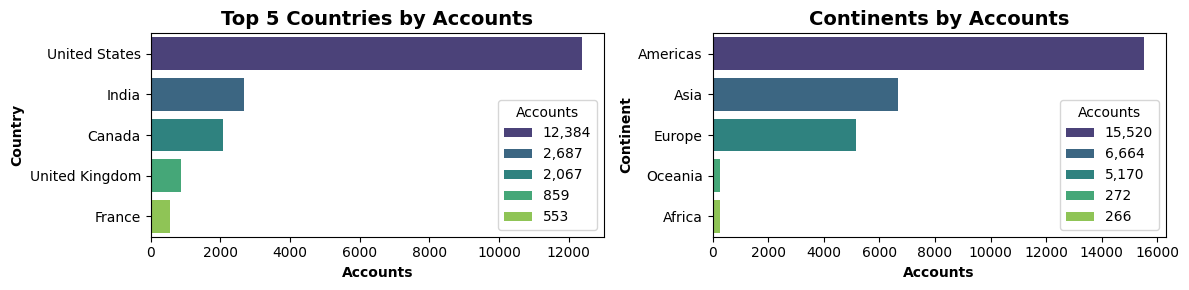

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

sns.barplot(
    data=accounts_by_country.head(5),
    x="accounts", y="country", hue="accounts",
    palette=sns.color_palette("viridis_r", n_colors=5), ax=ax[0]
)
ax[0].set_title("Top 5 Countries by Accounts", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Accounts", fontsize=10, fontweight='bold')
ax[0].set_ylabel("Country", fontsize=10, fontweight='bold')
ax[0].ticklabel_format(style='plain', axis='x')

handles, labels = ax[0].get_legend_handles_labels()
labels = [float(lbl) for lbl in labels]
sorted_pairs = sorted(zip(labels, handles), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_pairs)
sorted_labels = [f"{lbl:,.0f}" for lbl in sorted_labels]
ax[0].legend(sorted_handles, sorted_labels, title="Accounts")

sns.barplot(
    data=accounts_by_continent[accounts_by_continent.index != "(not set)"],
    x="accounts", y="continent", hue="accounts",
    palette=sns.color_palette("viridis_r", n_colors=len(accounts_by_continent)-1), ax=ax[1]
)
ax[1].set_title("Continents by Accounts", fontsize=14, fontweight='bold')
ax[1].set_xlabel("Accounts", fontsize=10, fontweight='bold')
ax[1].set_ylabel("Continent", fontsize=10, fontweight='bold')
ax[1].ticklabel_format(style='plain', axis='x')

handles, labels = ax[1].get_legend_handles_labels()
labels = [float(lbl) for lbl in labels]
sorted_pairs = sorted(zip(labels, handles), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_pairs)
sorted_labels = [f"{lbl:,.0f}" for lbl in sorted_labels]
ax[1].legend(sorted_handles, sorted_labels, title="Accounts")

plt.tight_layout()
plt.show()

## Sales by date

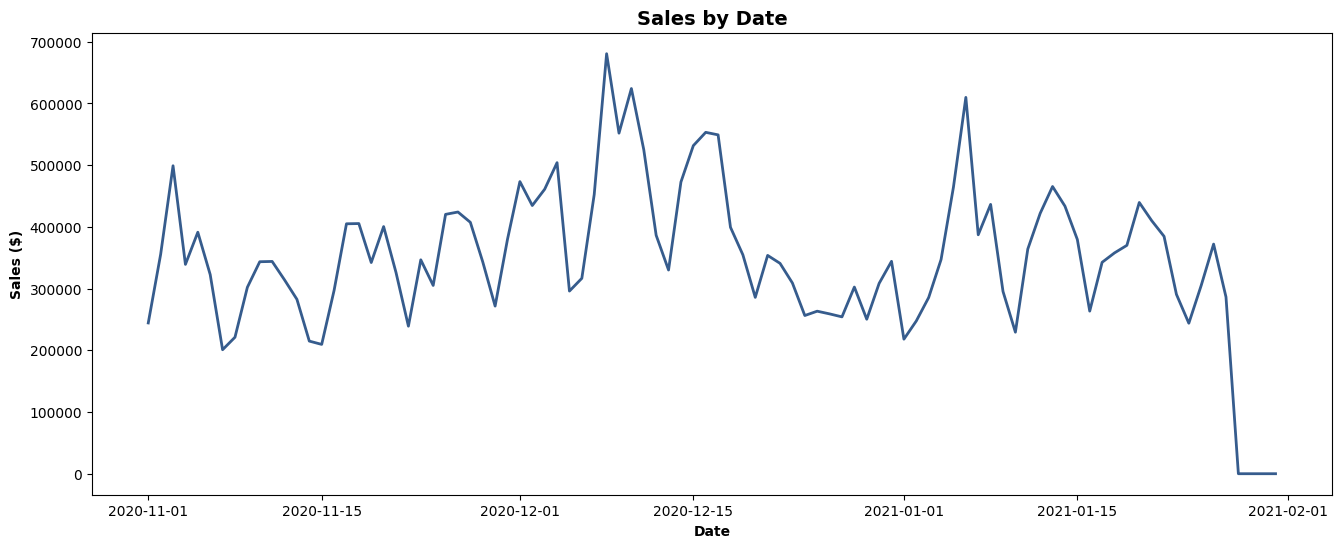

In [ ]:
# Sales by date
by_date = df.groupby("date").agg(sales=("price", "sum"))

plt.figure(figsize=(16, 6))

color = sns.color_palette("viridis")[1]

plt.plot(by_date.index, by_date["sales"], color=color, linewidth=2)
plt.title("Sales by Date", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=10, fontweight='bold')
plt.ylabel("Sales ($)", fontsize=10, fontweight='bold')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

In [ ]:
# Sales by year, month, day of week
by_year = df.groupby([df["date"].dt.year]).agg(sales=("price", "sum")
                           ).rename_axis(index='year').reset_index()
by_month = df.groupby([df["date"].dt.year, df["date"].dt.month]).agg(sales=("price", "sum")
                            ).rename_axis(index=['year', 'month']).reset_index()
by_month["month_year"] = by_month["year"].astype(str) + "-" + by_month["month"].astype(str)
by_day_of_week = df.groupby([df["date"].dt.day_name()]).agg(sales=("price", "sum")
                                  ).rename_axis(index="day_of_week")
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
by_day_of_week = by_day_of_week.reindex(days_order).reset_index()

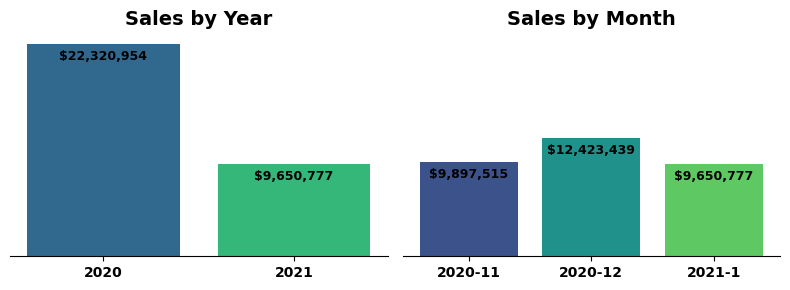

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

colors_years = sns.color_palette("viridis", len(by_year))
colors_months = sns.color_palette("viridis", len(by_month))

bars = ax[0].bar(by_year["year"], by_year["sales"], color=colors_years)
ax[0].set_title("Sales by Year", fontsize=14, fontweight='bold')
ax[0].set_xticks(by_year["year"])
ax[0].set_xticklabels(by_year["year"], fontweight='bold')
ax[0].set_yticks([])
ax[0].spines[['top', 'left', 'right']].set_visible(False)


for bar in bars:
    ax[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 2_000_000,
               f'${bar.get_height():,.0f}',
               ha='center', va='bottom', fontsize=9, fontweight='bold')

bars = ax[1].bar(by_month["month_year"], by_month["sales"], color=colors_months)
ax[1].set_title("Sales by Month", fontsize=14, fontweight='bold')
ax[1].set_xticks(range(len(by_month)))
ax[1].set_xticklabels(by_month["month_year"], fontweight='bold')
ax[0].set_yticks([])
ax[1].spines[['top', 'left', 'right']].set_visible(False)

for bar in bars:
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 2_000_000,
               f'${bar.get_height():,.0f}',
               ha='center', va='bottom', fontsize=9, fontweight='bold')


plt.tight_layout()
plt.show()

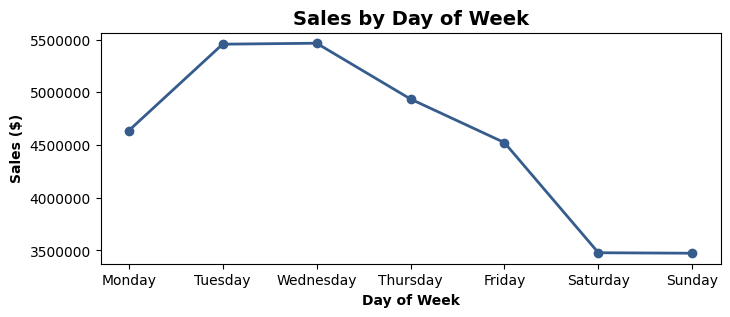

In [ ]:
plt.figure(figsize=(8, 3))

color = sns.color_palette("viridis")[1]

plt.plot(by_day_of_week["day_of_week"], by_day_of_week["sales"],
         marker='o', color=color, linewidth=2)
plt.title("Sales by Day of Week", fontsize=14, fontweight='bold')
plt.xlabel("Day of Week", fontsize=10, fontweight='bold')
plt.ylabel("Sales ($)", fontsize=10, fontweight='bold')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

## Sales by date and geography

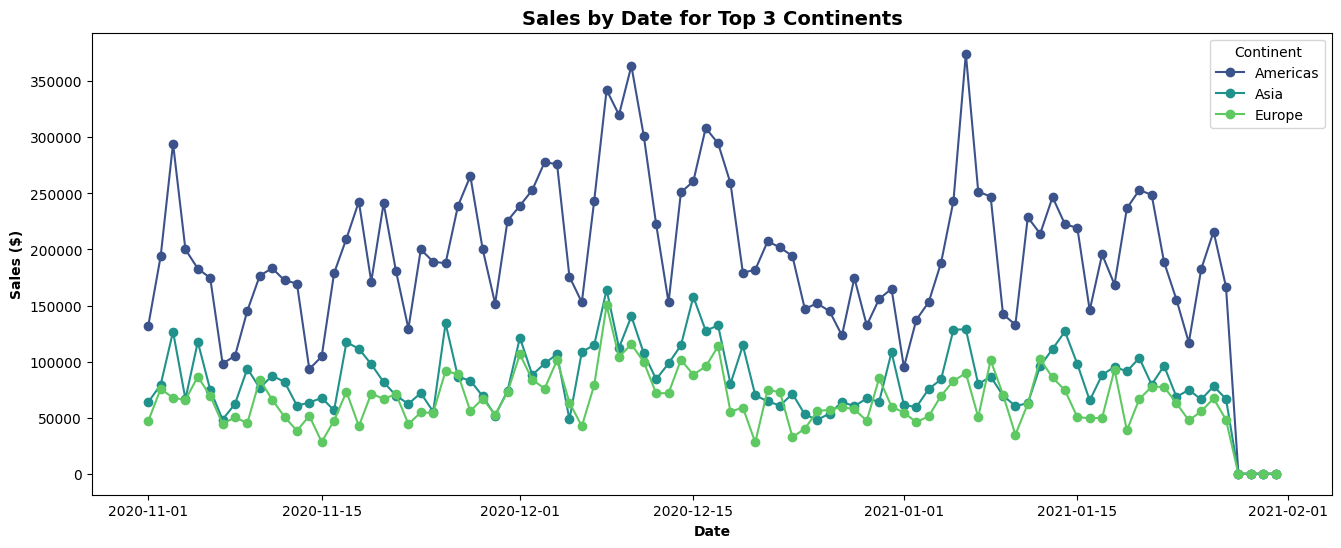

In [ ]:
# Sales by date and continent
by_date_and_continent = pd.pivot_table(
    df,
    values="price",
    index="date",
    columns="continent",
    aggfunc="sum"
).rename(columns={"price": "sales"})

metrics = by_continent.nlargest(3, "sales").index.tolist()

plt.figure(figsize=(16, 6))

palette = sns.color_palette("viridis", len(metrics))
colors = dict(zip(metrics, palette))

for metric in metrics:
    plt.plot(
        by_date_and_continent.index,
        by_date_and_continent[metric],
        marker='o',
        label=metric, color=colors[metric]
    )

plt.title("Sales by Date for Top 3 Continents", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=10, fontweight='bold')
plt.ylabel("Sales ($)", fontsize=10, fontweight='bold')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title="Continent", fontsize=10)

plt.show()

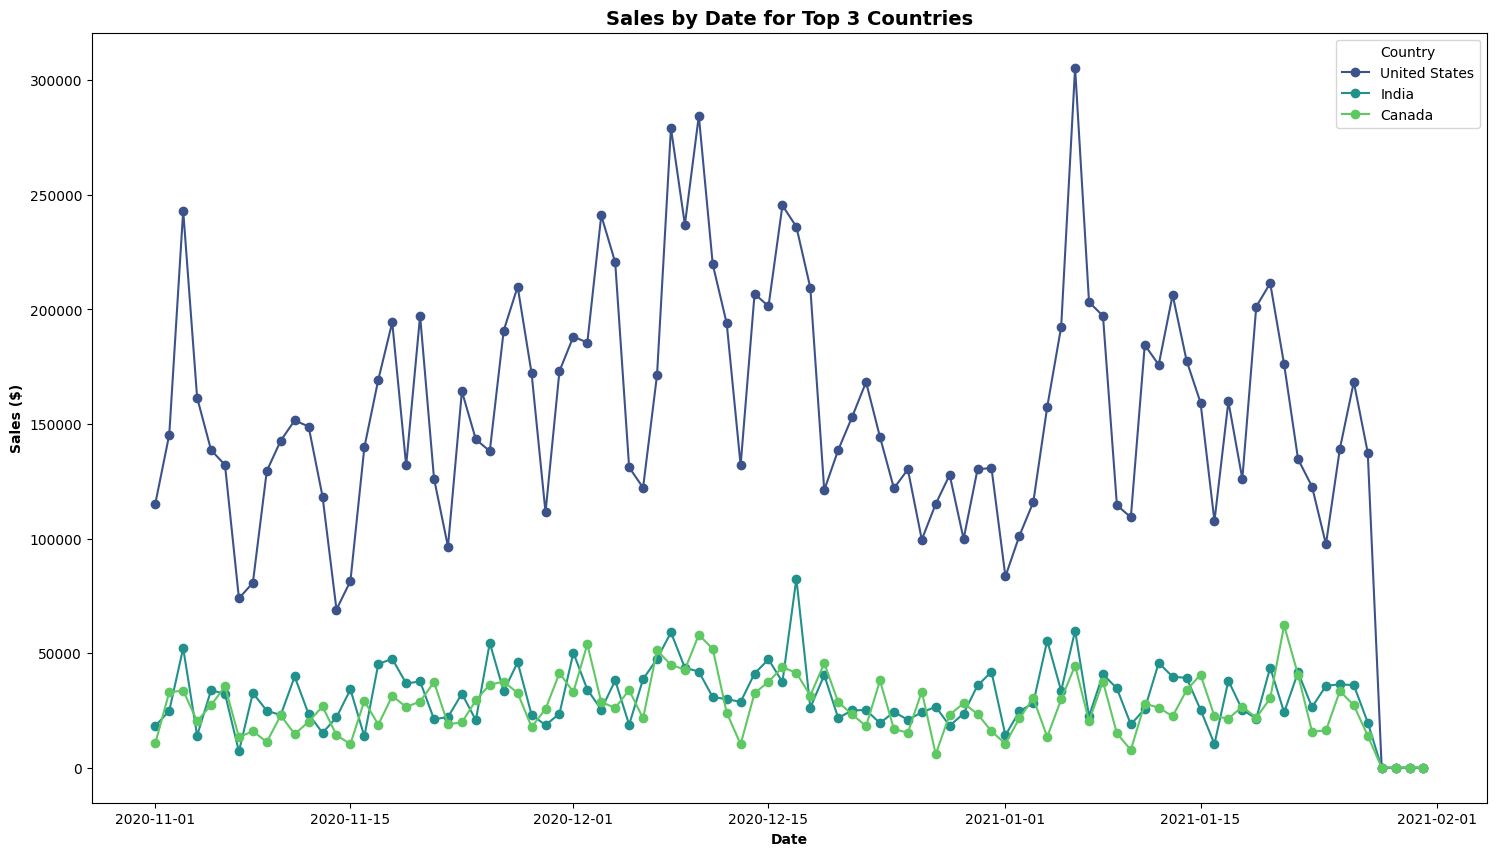

In [ ]:
# Sales by date and country
by_date_and_country = pd.pivot_table(
    df,
    values="price",
    index="date",
    columns="country",
    aggfunc="sum"
).rename(columns={"price": "sales"})

metrics = by_country.nlargest(3, "sales").index.tolist()

plt.figure(figsize=(18, 10))

palette = sns.color_palette("viridis", len(metrics))
colors = dict(zip(metrics, palette))

for metric in metrics:
    plt.plot(
        by_date_and_country.index,
        by_date_and_country[metric],
        marker='o',
        label=metric, color=colors[metric]
    )

plt.title("Sales by Date for Top 3 Countries", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=10, fontweight='bold')
plt.ylabel("Sales ($)", fontsize=10, fontweight='bold')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title="Country", fontsize=10)

plt.show()

## Sales by date and channel

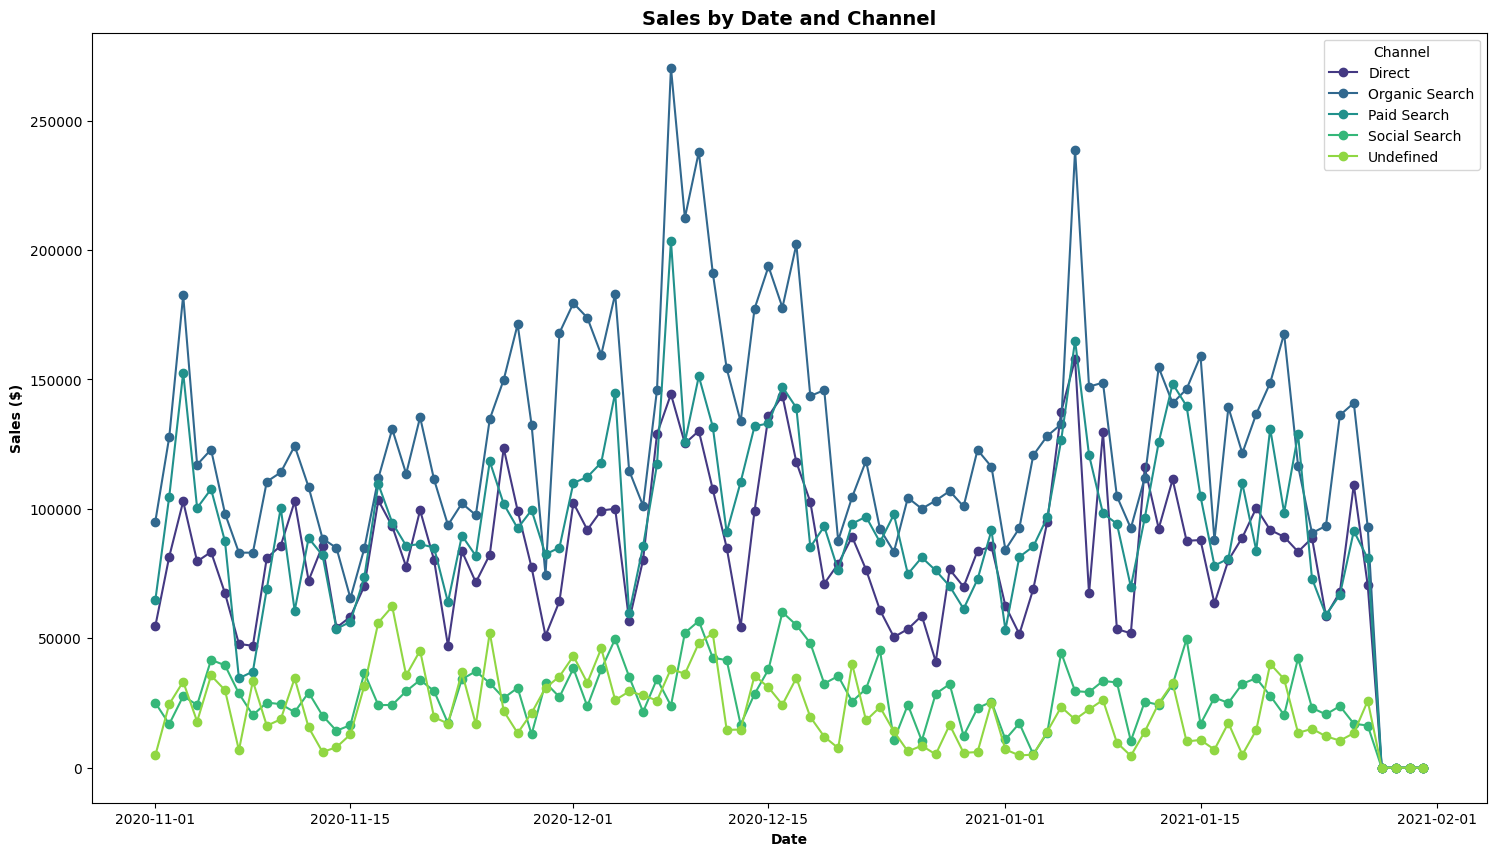

In [ ]:
# Sales by date and channel
by_date_and_channel = pd.pivot_table(
    df,
    values="price",
    index="date",
    columns="channel",
    aggfunc="sum"
).rename(columns={"price": "sales"})

plt.figure(figsize=(18, 10))

palette = sns.color_palette("viridis", len(by_date_and_channel.columns))
colors = dict(zip(by_date_and_channel.columns, palette))

for channel in by_date_and_channel.columns:
    plt.plot(
        by_date_and_channel.index,
        by_date_and_channel[channel],
        marker='o',
        label=channel, color=colors[channel]
    )

plt.title("Sales by Date and Channel", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=10, fontweight='bold')
plt.ylabel("Sales ($)", fontsize=10, fontweight='bold')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title="Channel", fontsize=10)

plt.show()

## Sales by date and device type

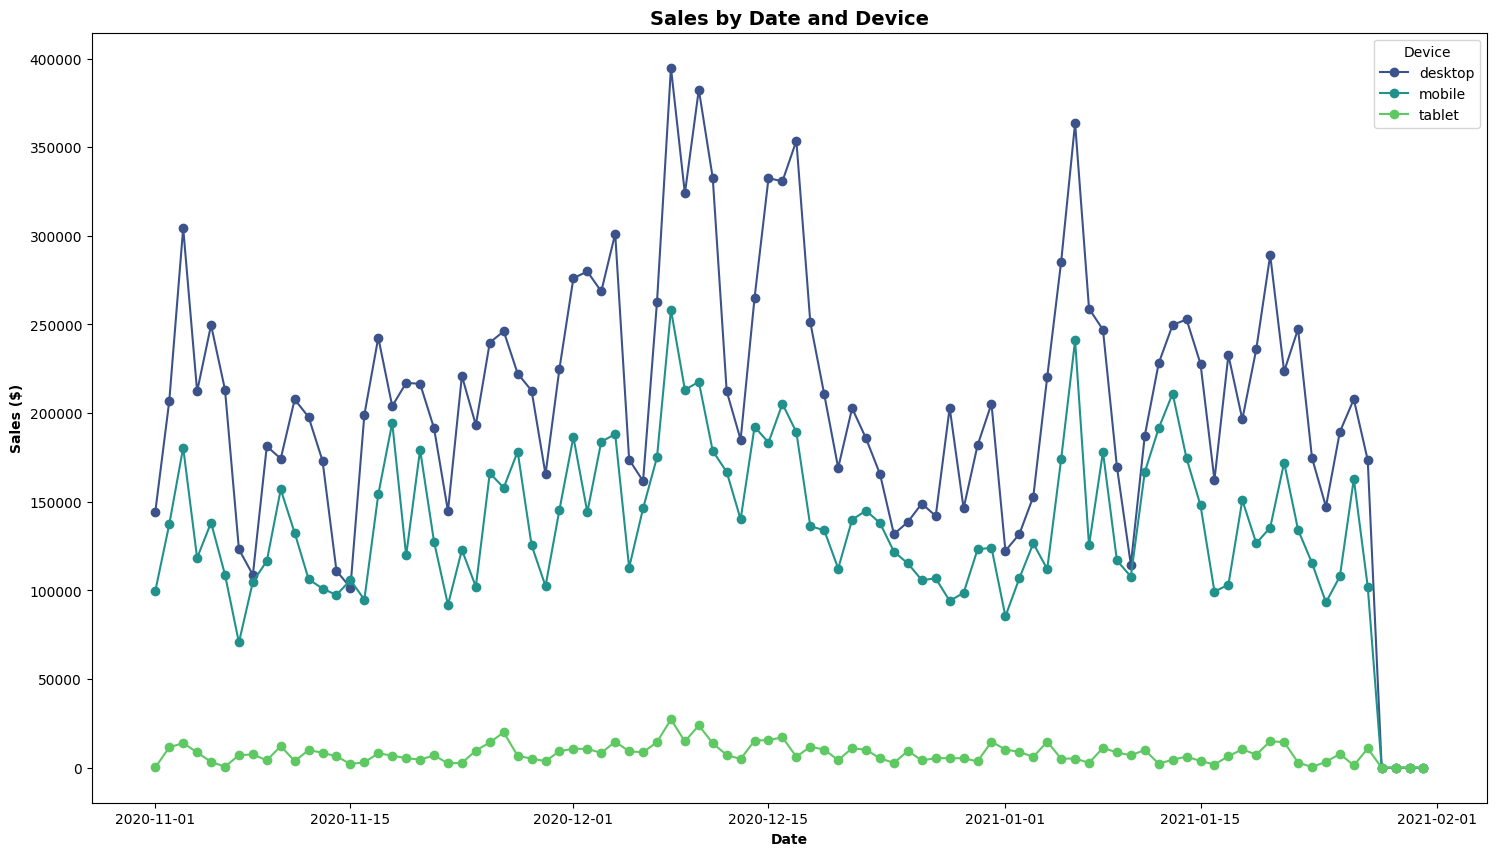

In [ ]:
# Sales by date and device type
by_date_and_device = pd.pivot_table(
    df,
    values="price",
    index="date",
    columns="device",
    aggfunc="sum"
).rename(columns={"price": "sales"})

plt.figure(figsize=(18, 10))

palette = sns.color_palette("viridis", len(by_date_and_device.columns))
colors = dict(zip(by_date_and_device.columns, palette))

for device in by_date_and_device.columns:
    plt.plot(
        by_date_and_device.index,
        by_date_and_device[device],
        marker='o',
        label=device, color=colors[device]
    )

plt.title("Sales by Date and Device", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=10, fontweight='bold')
plt.ylabel("Sales ($)", fontsize=10, fontweight='bold')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title="Device", fontsize=10)

plt.show()

## Sales by date for categories

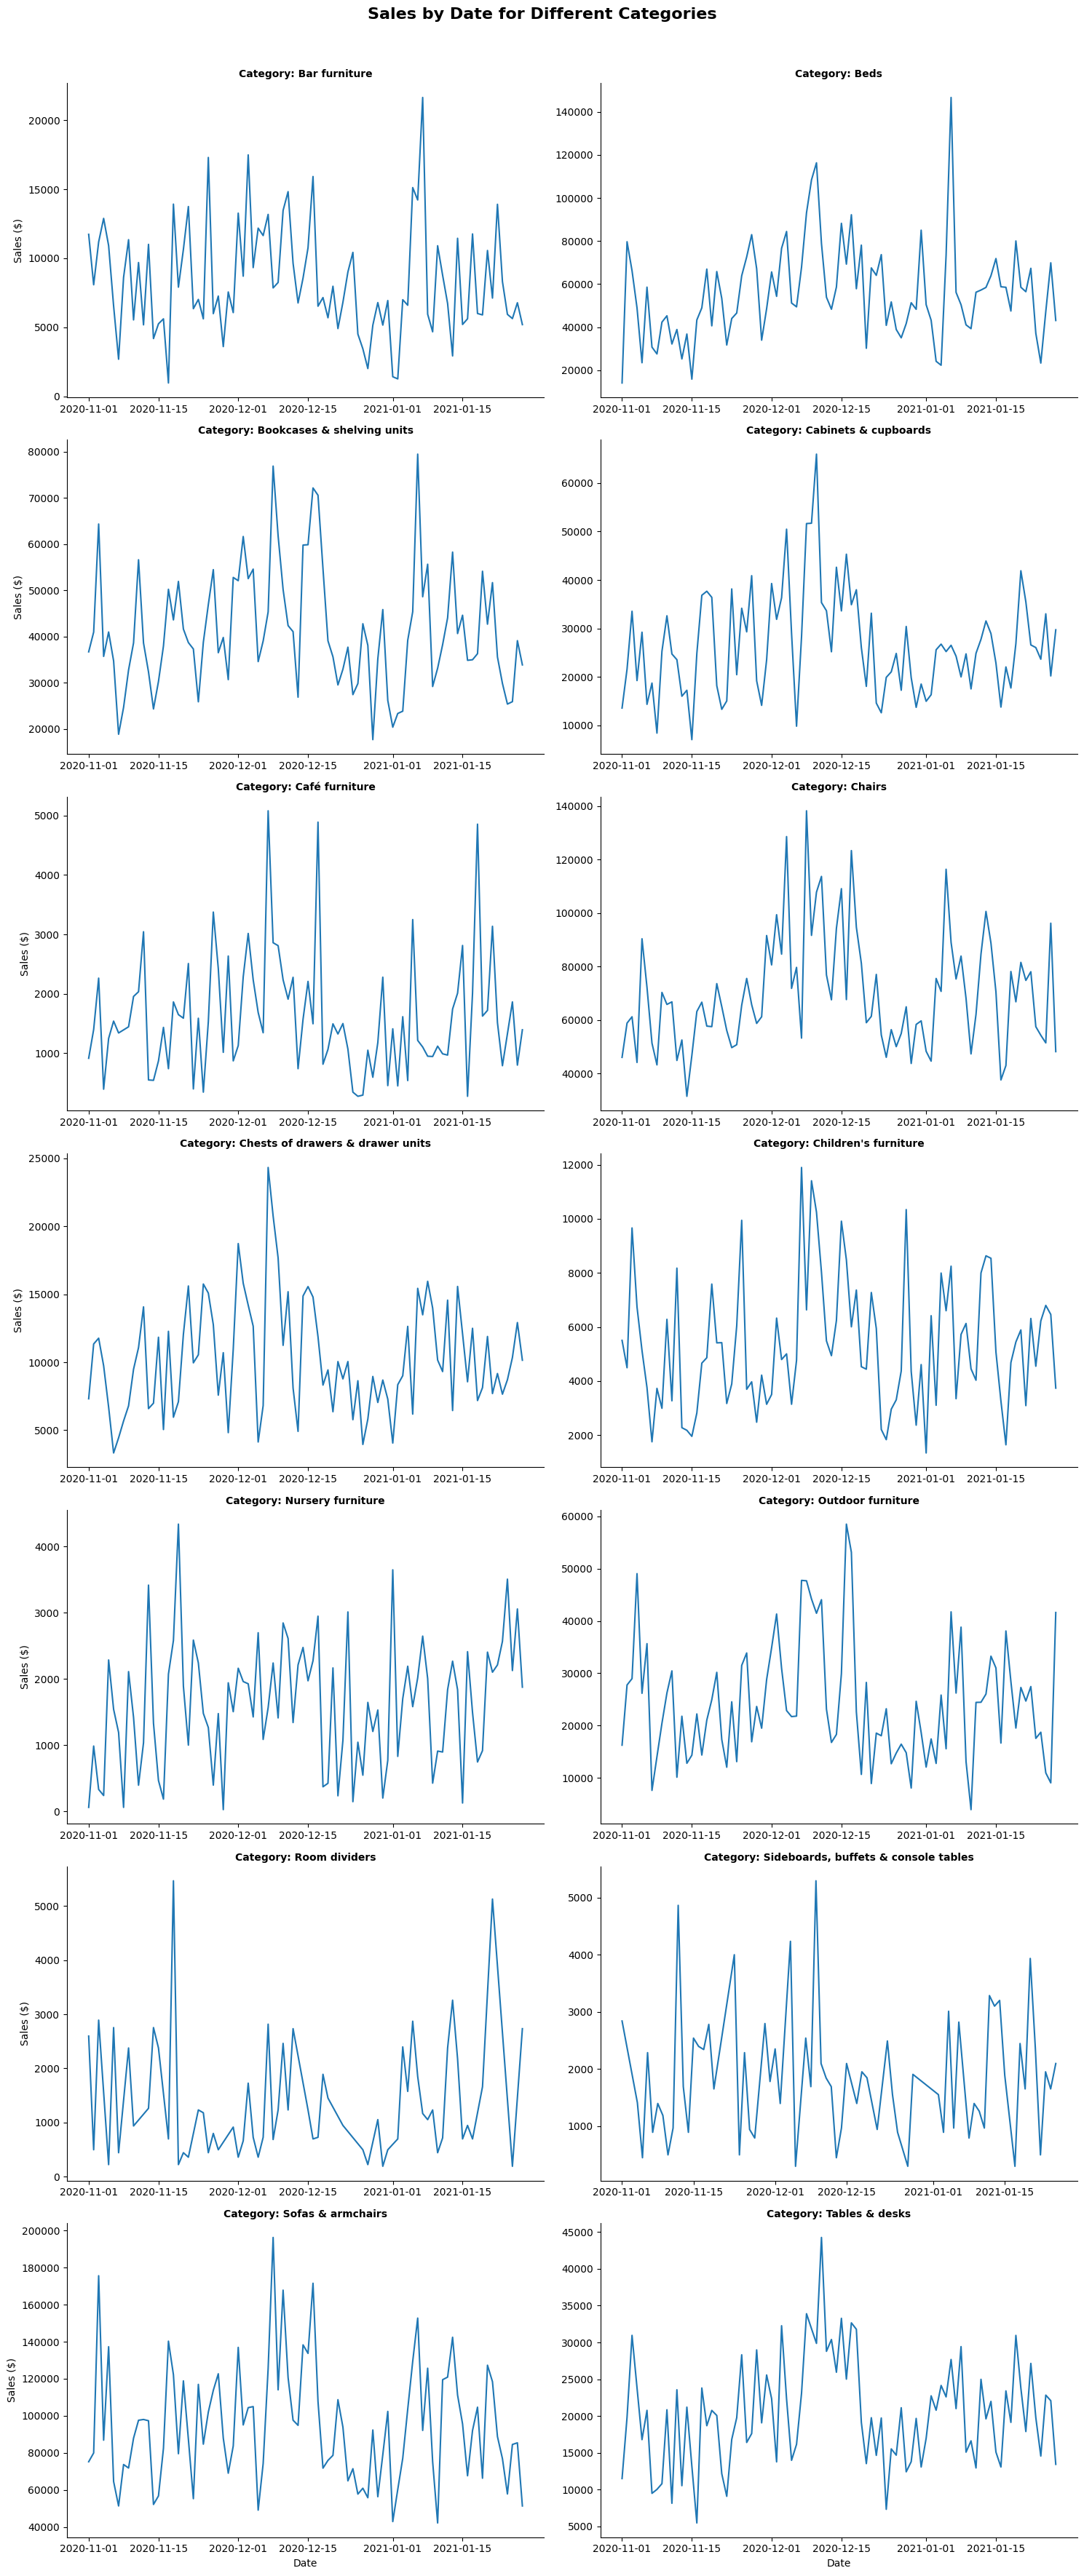

In [ ]:
# Sales by date for different categories
by_date_and_category = df.groupby(["date", "category"]).agg(sales=("price", "sum")).reset_index()

g = sns.relplot(
    data=by_date_and_category,
    x="date",
    y="sales",
    col="category",
    col_wrap=2,
    kind="line",
    height=5,
    aspect=1.5,
    facet_kws={'sharex': False, 'sharey': False}
)

g.fig.suptitle("Sales by Date for Different Categories", fontsize=16, fontweight='bold', y=1.01)
g.set_titles("Category: {col_name}", fontweight='bold')
g.set_axis_labels("Date", "Sales ($)")

for ax_sub in g.axes.flat:
  ax_sub.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

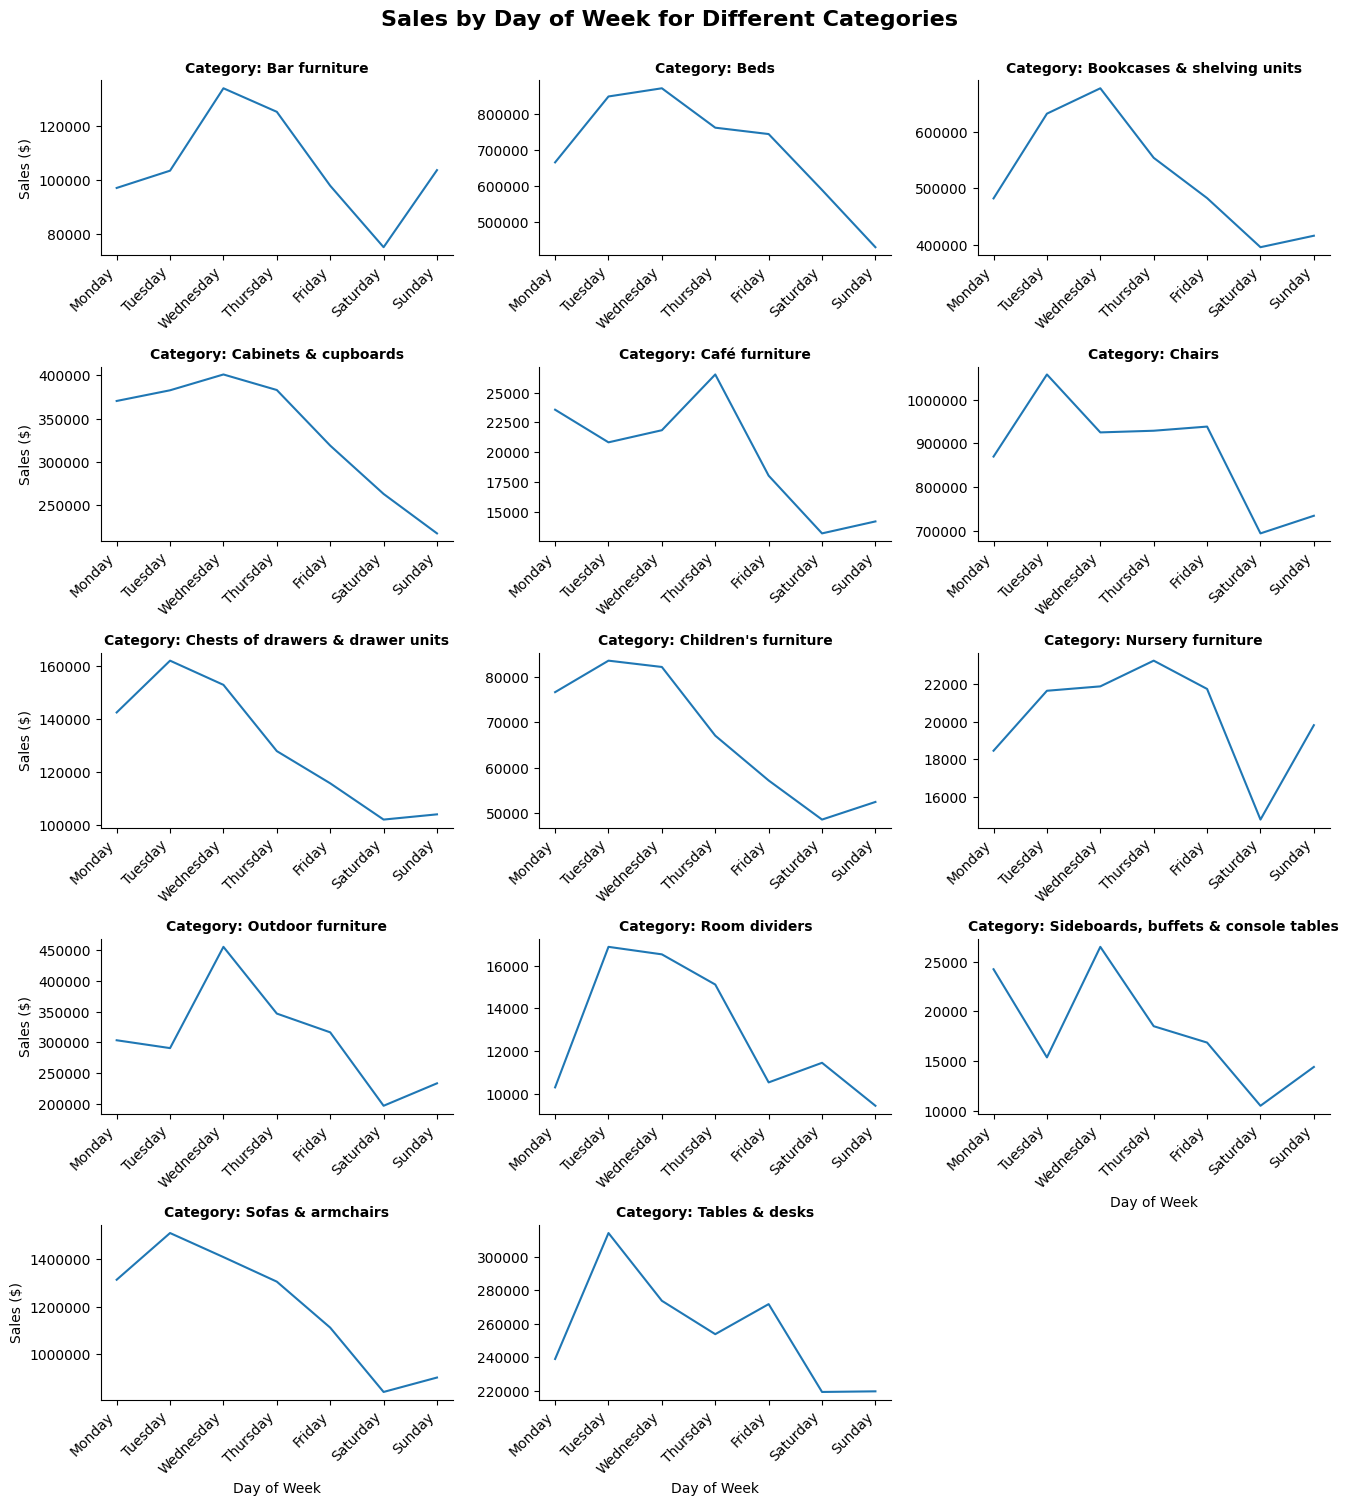

In [ ]:
# Sales by day of week for different categories
by_day_and_category = df.groupby([df["date"].dt.day_name(), "category"]).agg(sales=("price", "sum")).reset_index()
by_day_and_category["date"] = pd.Categorical(
    by_day_and_category["date"],
    categories=days_order,
    ordered=True
)

g = sns.relplot(
    data=by_day_and_category,
    x="date",
    y="sales",
    col="category",
    col_wrap=3,
    kind="line",
    height=3,
    aspect=1.5,
    facet_kws={'sharex': False, 'sharey': False}
)

g.fig.suptitle("Sales by Day of Week for Different Categories", fontsize=16, fontweight='bold', y=1.001)
g.set_titles("Category: {col_name}", fontweight='bold')
g.set_axis_labels("Day of Week", "Sales ($)")

for ax_sub in g.axes.flat:
    num_days = len(days_order)
    ax_sub.set_xticks(range(num_days))
    ax_sub.set_xticklabels(days_order, rotation=45, ha='right')
    ax_sub.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

## Sessions by channel and device

In [ ]:
# Sessions by channel and device
by_channel_and_device = pd.pivot_table(
    df,
    values="ga_session_id",
    index="channel",
    columns="device",
    aggfunc="count")

print(by_channel_and_device)

device          desktop  mobile  tablet
channel                                
Direct            47825   31745    1812
Organic Search    72622   49014    2789
Paid Search       55167   37034    2140
Social Search     16288   10988     638
Undefined         12527    8486     470


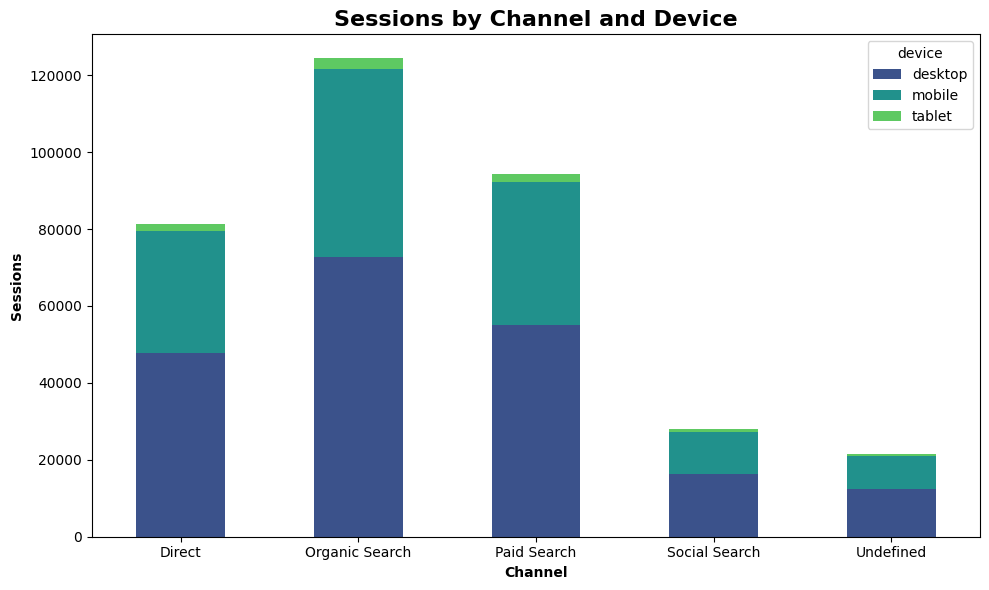

In [ ]:
color = sns.color_palette("viridis", 3)

ax = by_channel_and_device.plot(kind="bar", stacked=True, figsize=(10,6), color=color)
ax.set_title("Sessions by Channel and Device", fontsize=16, fontweight='bold')
ax.set_xlabel("Channel", fontsize=10, fontweight='bold')
ax.set_ylabel("Sessions", fontsize=10, fontweight='bold')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## Sessions by browser and device

In [ ]:
# Sessions by browser and device
by_browser_and_device = pd.pivot_table(
    df,
    values="ga_session_id",
    index="browser",
    columns="device",
    aggfunc="count")

print(by_browser_and_device)

device           desktop  mobile  tablet
browser                                 
<Other>             2313    6000     617
Android Webview     <NA>    4227     218
Chrome            171859   62706    3895
Edge                8016       7    <NA>
Firefox             6063     370    <NA>
Safari             16178   63957    3119


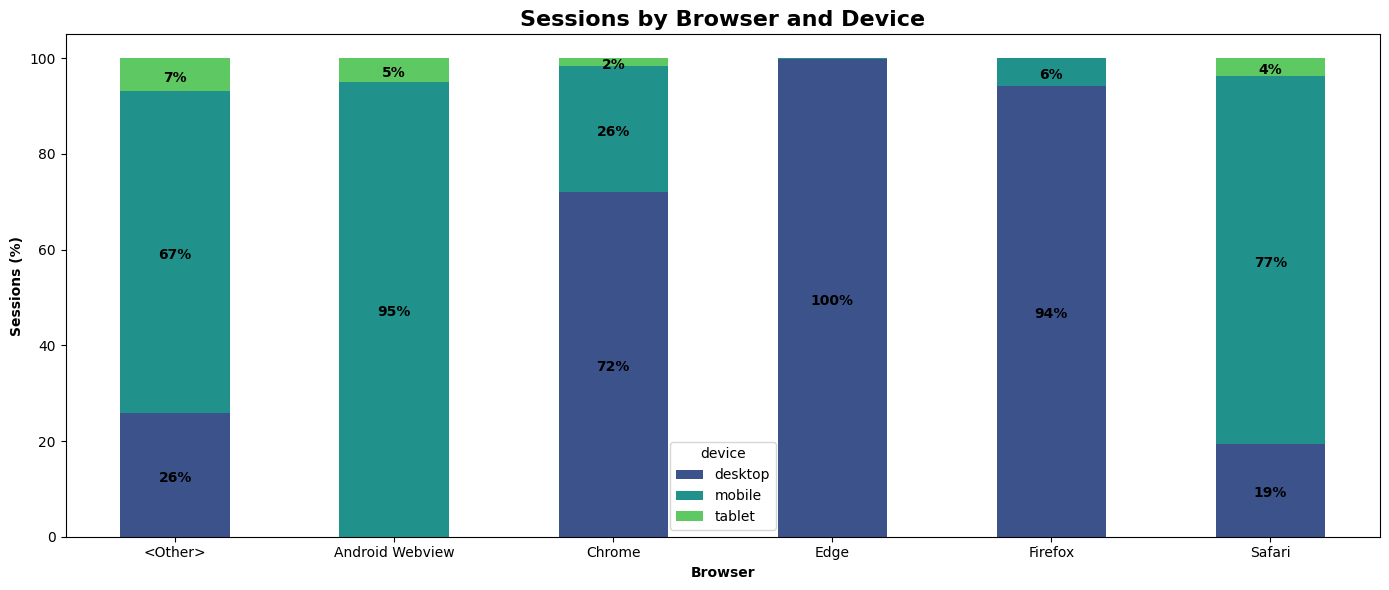

In [ ]:
color = sns.color_palette("viridis", 3)

by_browser_and_device_percent = by_browser_and_device.div(by_browser_and_device.sum(axis=1), axis=0) * 100

ax = by_browser_and_device_percent.plot(kind="bar", stacked=True, figsize=(14,6), color=color)
ax.set_title("Sessions by Browser and Device", fontsize=16, fontweight='bold')
ax.set_xlabel("Browser", fontsize=10, fontweight='bold')
ax.set_ylabel("Sessions (%)", fontsize=10, fontweight='bold')
plt.xticks(rotation=0)

for bar in ax.patches:
    if bar.get_height() > 0.1:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2 + bar.get_y() - 1.5,
            f'{bar.get_height():.0f}%',
            ha='center',
            weight='bold',
        )

plt.tight_layout()
plt.show()

## Sessions by country and channel

In [ ]:
# Sessions by country and channel
by_country_and_channel = pd.pivot_table(
    df,
    values="ga_session_id",
    index="country",
    columns="channel",
    aggfunc="count")

display(by_country_and_channel)

channel         Direct  Organic Search  Paid Search  Social Search  Undefined
country                                                                      
(not set)          637            1045          720            222        184
Albania             18              42           23              8          6
Algeria             47              78           62             13         14
Argentina          201             328          225             78         45
Armenia             20              24           22             15          3
...                ...             ...          ...            ...        ...
United Kingdom    2541            3954         2985            844        679
United States    35803           54435        41503          12194       9535
Uruguay             35              56           45             16         18
Venezuela           30              46           39              9         15
Vietnam            333             524          390            129        103

[108 rows x 5 columns]

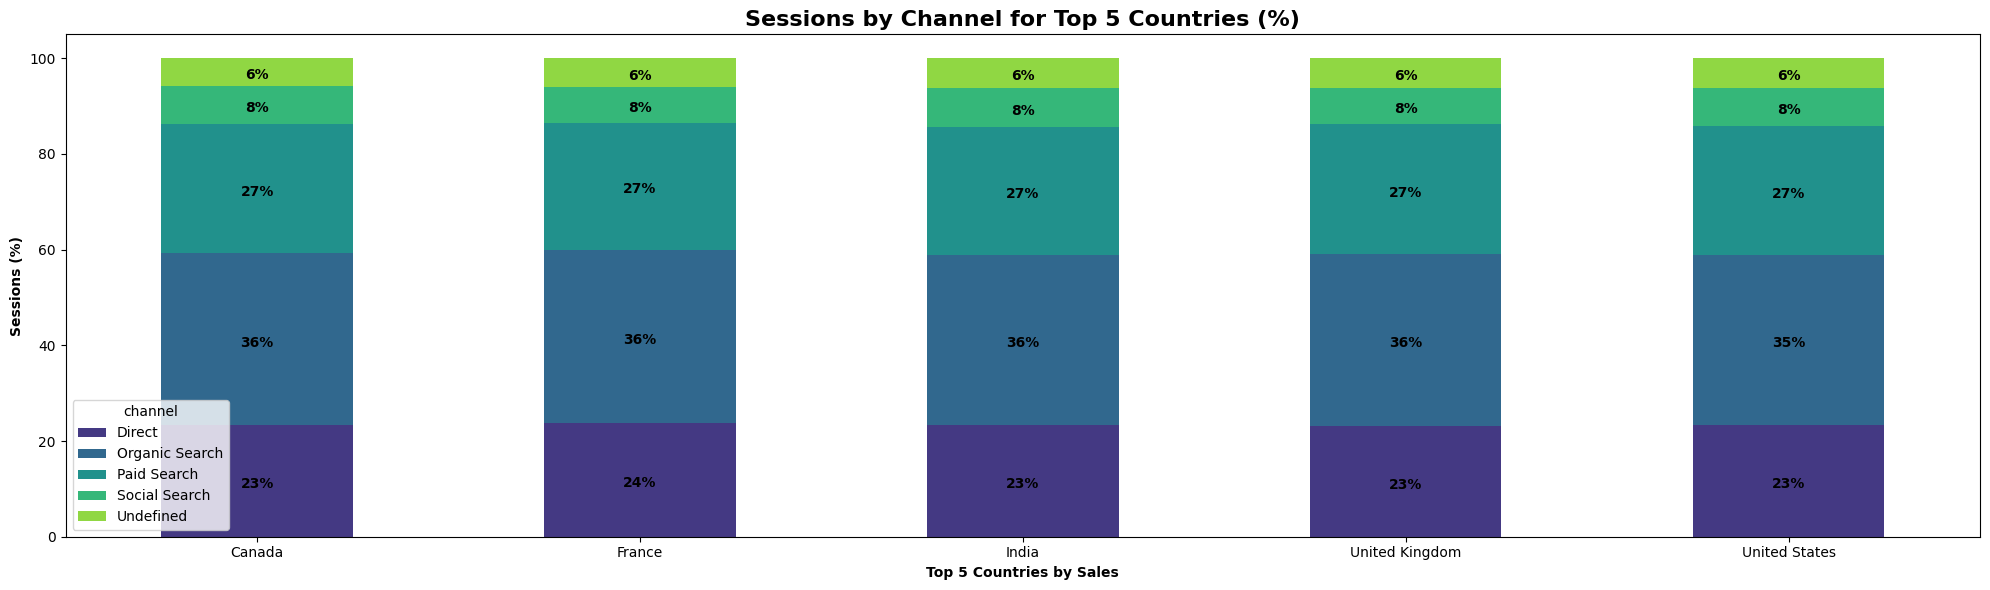

In [ ]:
by_top5_country_and_channel = by_country_and_channel[by_country_and_channel.index
                                                        .isin(top5_countries_by_sales)]

by_top5_country_and_channel_percent = by_top5_country_and_channel.div(by_top5_country_and_channel.sum(axis=1), axis=0) * 100

color = sns.color_palette("viridis", 5)

ax = by_top5_country_and_channel_percent.plot(kind="bar", stacked=True, figsize=(20,6), color=color)
ax.set_title("Sessions by Channel for Top 5 Countries (%)", fontsize=16, fontweight='bold')
ax.set_xlabel("Top 5 Countries by Sales", fontsize=10, fontweight='bold')
ax.set_ylabel("Sessions (%)", fontsize=10, fontweight='bold')
plt.xticks(rotation=0)

for bar in ax.patches:
    if bar.get_height() > 0.1:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2 + bar.get_y() - 1.5,
            f'{bar.get_height():.0f}%',
            ha='center',
            weight='bold',
        )

plt.tight_layout()
plt.show()

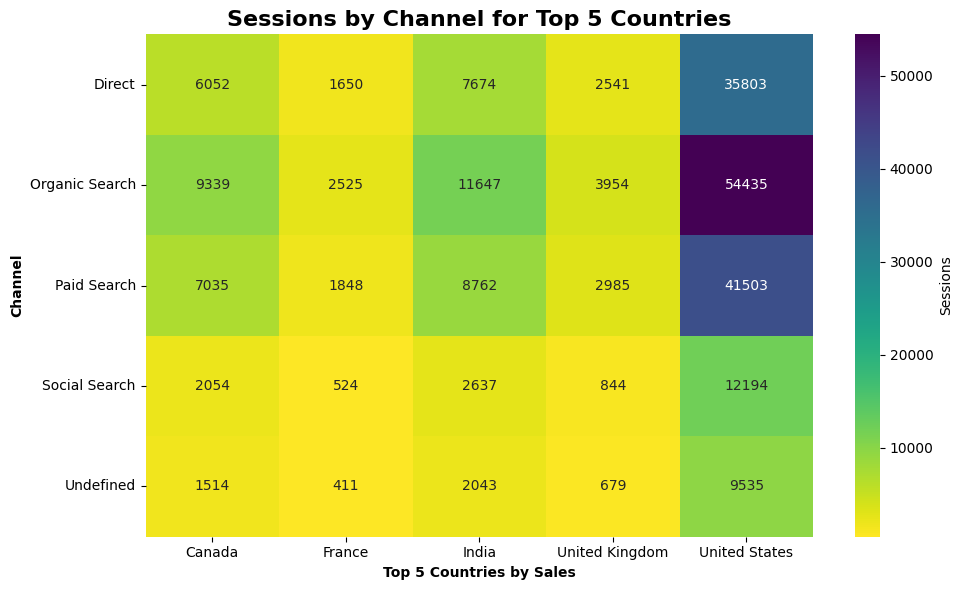

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(
    by_top5_country_and_channel.T.astype(float),
    annot=True,
    fmt=".0f",
    cmap="viridis_r",
    cbar_kws={"label": "Sessions"}
)

plt.title("Sessions by Channel for Top 5 Countries", fontsize=16, fontweight='bold')
plt.ylabel("Channel", fontsize=10, fontweight='bold')
plt.xlabel("Top 5 Countries by Sales", fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

## Sessions by date and channel

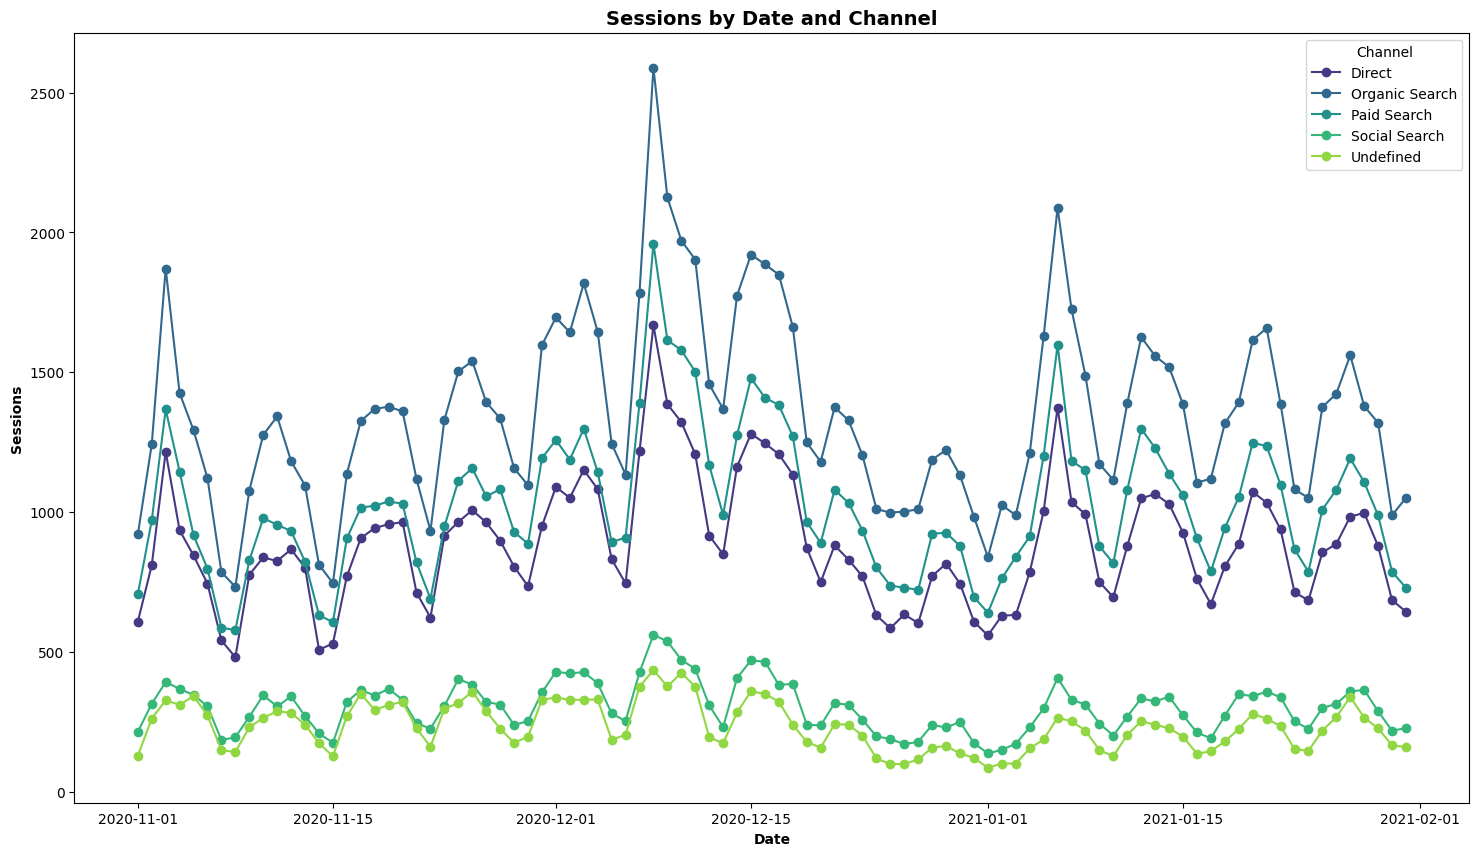

In [ ]:
# Sessions by date and channel
sessions_by_date_and_channel = pd.pivot_table(
    df,
    values="ga_session_id",
    index="date",
    columns="channel",
    aggfunc="count"
).rename(columns={"ga_session_id": "sessions"})

plt.figure(figsize=(18, 10))

palette = sns.color_palette("viridis", len(sessions_by_date_and_channel.columns))
colors = dict(zip(sessions_by_date_and_channel.columns, palette))

for channel in sessions_by_date_and_channel.columns:
    plt.plot(
        sessions_by_date_and_channel.index,
        sessions_by_date_and_channel[channel],
        marker='o',
        label=channel, color=colors[channel]
    )

plt.title("Sessions by Date and Channel", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=10, fontweight='bold')
plt.ylabel("Sessions", fontsize=10, fontweight='bold')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title="Channel", fontsize=10)

plt.show()

# **Statistical analysis of relationships**

## Sales and sessions by date

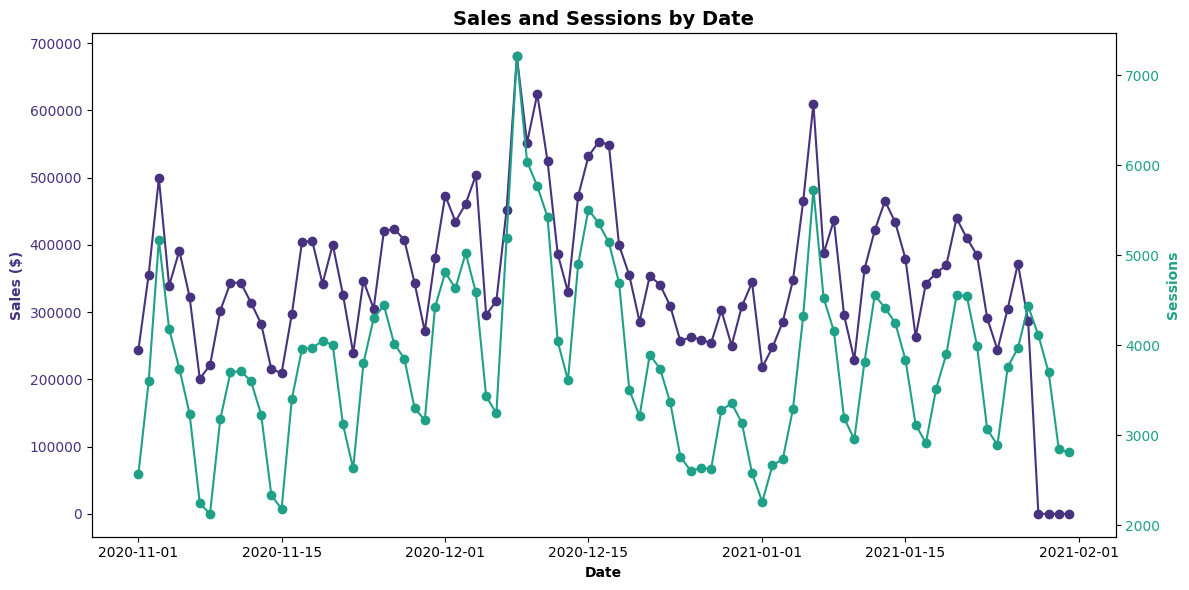

In [ ]:
# Sales and sessions by date
sales_and_sessions_by_date = df.groupby("date").agg(sales=("price", "sum"), sessions=("ga_session_id", "count")).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

color_sales = sns.color_palette("viridis")[0]
color_sessions = sns.color_palette("viridis")[3]

ax1.plot(sales_and_sessions_by_date["date"], sales_and_sessions_by_date["sales"], marker='o', color=color_sales, label="Sales")
ax1.set_xlabel("Date", fontsize=10, fontweight='bold')
ax1.set_ylabel("Sales ($)", color=color_sales, fontsize=10, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_sales)

ax2 = ax1.twinx()
ax2.plot(sales_and_sessions_by_date["date"], sales_and_sessions_by_date["sessions"], marker='o', color=color_sessions, label="Sessions")
ax2.set_ylabel("Sessions", color=color_sessions, fontsize=10, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_sessions)

plt.title("Sales and Sessions by Date", fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

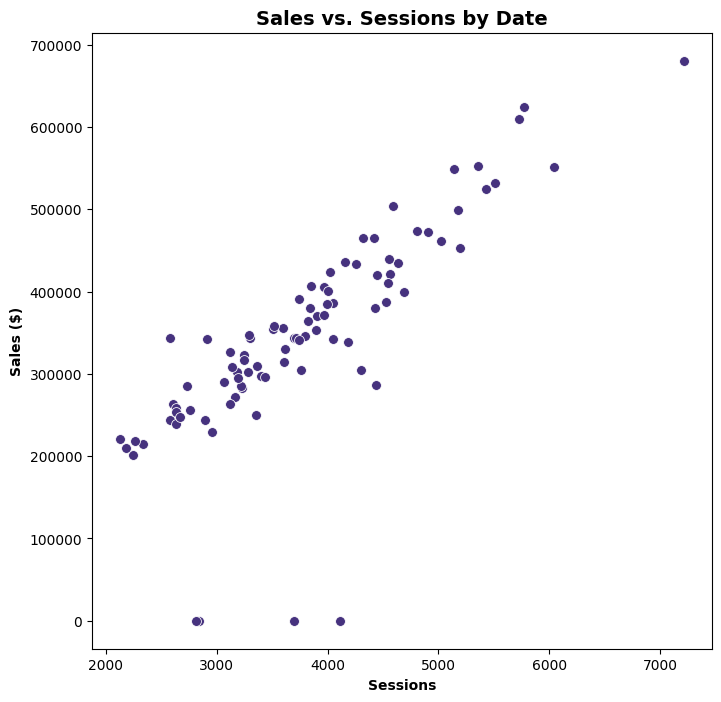

In [ ]:
plt.figure(figsize=(8, 8))

sns.scatterplot(x="sessions", y="sales", data=sales_and_sessions_by_date, s=50, color=sns.color_palette("viridis")[0])
plt.title("Sales vs. Sessions by Date", fontsize=14, fontweight='bold')
plt.xlabel("Sessions", fontsize=10, fontweight='bold')
plt.ylabel("Sales ($)", fontsize=10, fontweight='bold')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

In [ ]:
# Calculating Pearson correlation
r, p_value = pearsonr(sales_and_sessions_by_date["sessions"], sales_and_sessions_by_date["sales"])

print(f"Pearson correlation coefficient (r): {r:.3f}")
print(f"p-value: {p_value:.3g}")
print("Significant" if p_value < 0.05 else "Not significant")

Pearson correlation coefficient (r): 0.791
p-value: 6.48e-21
Significant


## Sales across top-3 continents

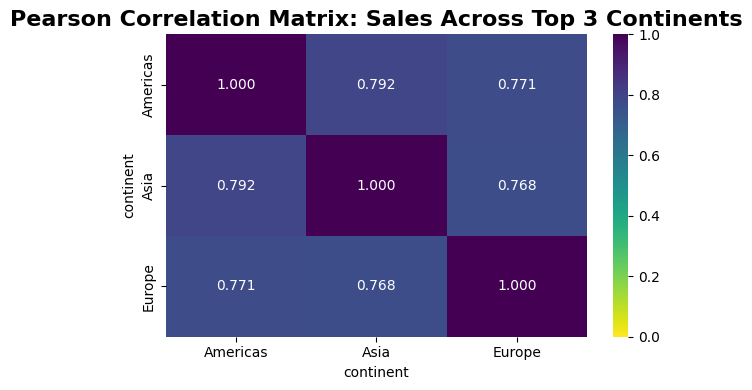

In [ ]:
# Calculating correlation across top-3 continents
sales_for_top3_continents_by_date = by_date_and_continent[by_continent.nlargest(3, "sales").index]

plt.figure(figsize=(6,4))
sns.heatmap(
    sales_for_top3_continents_by_date.corr(method="pearson"),
    annot=True,
    fmt=".3f",
    cmap="viridis_r",
    vmin=0,
    vmax=1
)

plt.title("Pearson Correlation Matrix: Sales Across Top 3 Continents", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
for c_1, c_2 in itertools.combinations(sales_for_top3_continents_by_date, 2):
    r, p_value = pearsonr(sales_for_top3_continents_by_date[c_1], sales_for_top3_continents_by_date[c_2])
    print(f"{c_1} vs {c_2}: r = {r:.3f}, p-value = {p_value:.2e}")
    print("Significant" if p_value < 0.05 else "Not significant")

Americas vs Asia: r = 0.792, p-value = 5.41e-21
Significant
Americas vs Europe: r = 0.771, p-value = 2.67e-19
Significant
Asia vs Europe: r = 0.768, p-value = 3.86e-19
Significant


## Sales across top-3 countries

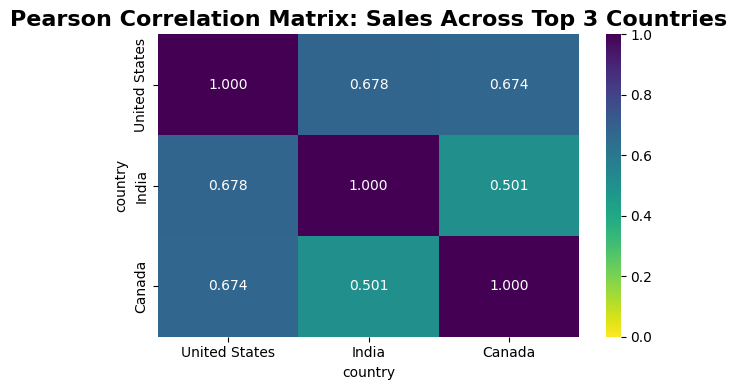

In [ ]:
# Calculating correlation across top-3 countries
sales_for_top3_countries_by_date = by_date_and_country[by_country.nlargest(3, "sales").index]

plt.figure(figsize=(6,4))
sns.heatmap(
    sales_for_top3_countries_by_date.corr(method="pearson"),
    annot=True,
    fmt=".3f",
    cmap="viridis_r",
    vmin=0,
    vmax=1
)

plt.title("Pearson Correlation Matrix: Sales Across Top 3 Countries", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
for c_1, c_2 in itertools.combinations(sales_for_top3_countries_by_date, 2):
    r, p_value = pearsonr(sales_for_top3_countries_by_date[c_1], sales_for_top3_countries_by_date[c_2])
    print(f"{c_1} vs {c_2}: r = {r:.3f}, p-value = {p_value:.2e}")
    print("Significant" if p_value < 0.05 else "Not significant")

United States vs India: r = 0.678, p-value = 1.09e-13
Significant
United States vs Canada: r = 0.674, p-value = 1.72e-13
Significant
India vs Canada: r = 0.501, p-value = 3.63e-07
Significant


##Sales across channels

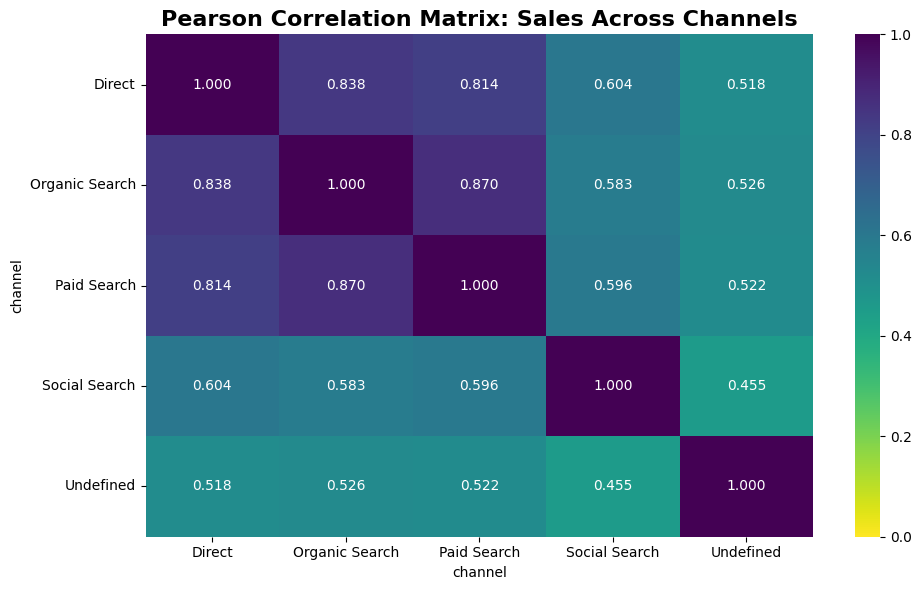

In [ ]:
# Calculating correlation across channels
plt.figure(figsize=(10,6))
sns.heatmap(
    by_date_and_channel.corr(method="pearson"),
    annot=True,
    fmt=".3f",
    cmap="viridis_r",
    vmin=0,
    vmax=1
)

plt.title("Pearson Correlation Matrix: Sales Across Channels", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
for c_1, c_2 in itertools.combinations(by_date_and_channel, 2):
    r, p_value = pearsonr(by_date_and_channel[c_1], by_date_and_channel[c_2])
    print(f"{c_1} vs {c_2}: r = {r:.3f}, p-value = {p_value:.2e}")
    print("Significant" if p_value < 0.05 else "Not significant")

Direct vs Organic Search: r = 0.838, p-value = 2.19e-25
Significant
Direct vs Paid Search: r = 0.814, p-value = 5.90e-23
Significant
Direct vs Social Search: r = 0.604, p-value = 1.83e-10
Significant
Direct vs Undefined: r = 0.518, p-value = 1.28e-07
Significant
Organic Search vs Paid Search: r = 0.870, p-value = 2.14e-29
Significant
Organic Search vs Social Search: r = 0.583, p-value = 1.07e-09
Significant
Organic Search vs Undefined: r = 0.526, p-value = 7.23e-08
Significant
Paid Search vs Social Search: r = 0.596, p-value = 3.53e-10
Significant
Paid Search vs Undefined: r = 0.522, p-value = 9.51e-08
Significant
Social Search vs Undefined: r = 0.455, p-value = 5.16e-06
Significant


##Sales across devices

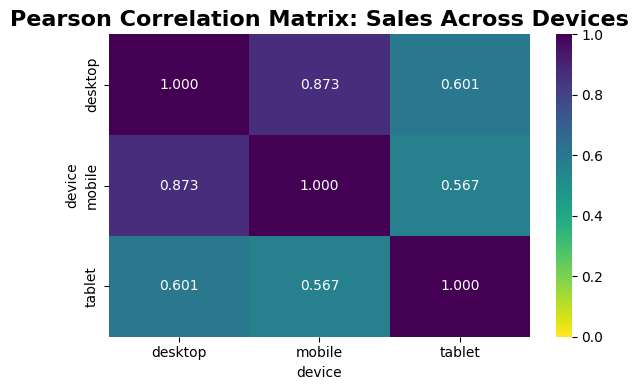

In [ ]:
# Calculating correlation across devices
plt.figure(figsize=(6,4))
sns.heatmap(
    by_date_and_device.corr(method="pearson"),
    annot=True,
    fmt=".3f",
    cmap="viridis_r",
    vmin=0,
    vmax=1
)

plt.title("Pearson Correlation Matrix: Sales Across Devices", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
for d_1, d_2 in itertools.combinations(by_date_and_device, 2):
    r, p_value = pearsonr(by_date_and_device[d_1], by_date_and_device[d_2])
    print(f"{d_1} vs {d_2}: r = {r:.3f}, p-value = {p_value:.2e}")
    print("Significant" if p_value < 0.05 else "Not significant")

desktop vs mobile: r = 0.873, p-value = 7.72e-30
Significant
desktop vs tablet: r = 0.601, p-value = 2.32e-10
Significant
mobile vs tablet: r = 0.567, p-value = 3.69e-09
Significant


##Sales across top-5 categories

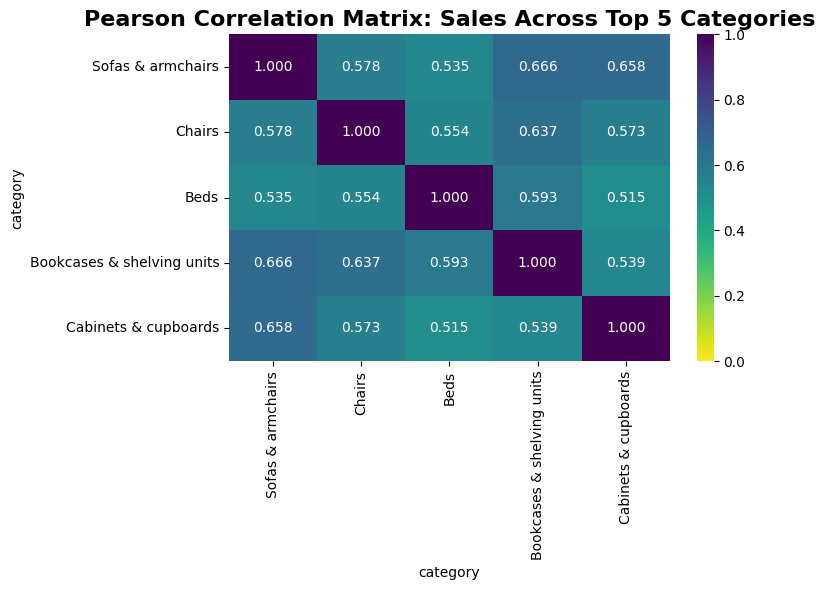

In [ ]:
# Calculating correlation across top-5 categories
sales_for_categories_by_date = pd.pivot_table(
    df,
    values="price",
    index="date",
    columns="category",
    aggfunc="sum"
)

sales_for_top5_categories_by_date = sales_for_categories_by_date[by_category.nlargest(5, "sales").index]

plt.figure(figsize=(8,6))
sns.heatmap(
    sales_for_top5_categories_by_date.corr(method="pearson"),
    annot=True,
    fmt=".3f",
    cmap="viridis_r",
    vmin=0,
    vmax=1
)

plt.title("Pearson Correlation Matrix: Sales Across Top 5 Categories", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
for c_1, c_2 in itertools.combinations(sales_for_top5_categories_by_date, 2):
    r, p_value = pearsonr(sales_for_top5_categories_by_date[c_1], sales_for_top5_categories_by_date[c_2])
    print(f"{c_1} vs {c_2}: r = {r:.3f}, p-value = {p_value:.2e}")
    print("Significant" if p_value < 0.05 else "Not significant")

Sofas & armchairs vs Chairs: r = 0.578, p-value = 3.64e-09
Significant
Sofas & armchairs vs Beds: r = 0.535, p-value = 7.69e-08
Significant
Sofas & armchairs vs Bookcases & shelving units: r = 0.666, p-value = 1.41e-12
Significant
Sofas & armchairs vs Cabinets & cupboards: r = 0.658, p-value = 3.42e-12
Significant
Chairs vs Beds: r = 0.554, p-value = 2.08e-08
Significant
Chairs vs Bookcases & shelving units: r = 0.637, p-value = 2.50e-11
Significant
Chairs vs Cabinets & cupboards: r = 0.573, p-value = 5.47e-09
Significant
Beds vs Bookcases & shelving units: r = 0.593, p-value = 1.15e-09
Significant
Beds vs Cabinets & cupboards: r = 0.515, p-value = 2.91e-07
Significant
Bookcases & shelving units vs Cabinets & cupboards: r = 0.539, p-value = 5.87e-08
Significant


# **Comparative Statistical Analysis**

##Sales of registered and unregistered users

In [ ]:
# Sales of registered and unregistered users by date
by_date_and_registered = pd.pivot_table(
    df,
    values="price",
    index="date",
    columns="is_registered",
    aggfunc="sum")

by_date_and_registered = by_date_and_registered.fillna(0)

# Normaltest
_, p_value_normaltest_registered = normaltest(by_date_and_registered[1])
_, p_value_normaltest_unregistered = normaltest(by_date_and_registered[0])

# Shapiro-Wilk test
_, p_value_shapiro_registered = shapiro(by_date_and_registered[1])
_, p_value_shapiro_unregistered = shapiro(by_date_and_registered[0])

# Test results
print("-=Normaltest=-")
print(f"Normaltest for registered users data p-value: {p_value_normaltest_registered:.3f}")
print("Normal Distribution" if p_value_normaltest_registered > 0.05 else "Non Normal Distribution")
print(f"Normaltest for unregistered users data p-value: {p_value_normaltest_unregistered:.3f}")
print("Normal Distribution" if p_value_normaltest_unregistered > 0.05 else "Non Normal Distribution")
print("-=Shapiro-Wilk test=-")
print(f"Shapiro-Wilk for registered users data p-value: {p_value_shapiro_registered:.3f}")
print("Normal Distribution" if p_value_shapiro_registered > 0.05 else "Non Normal Distribution")
print(f"Shapiro-Wilk for unregistered users data p-value: {p_value_shapiro_unregistered:.3f}")
print("Normal Distribution" if p_value_shapiro_unregistered > 0.05 else "Non Normal Distribution")


-=Normaltest=-
Normaltest for registered users data p-value: 0.257
Normal Distribution
Normaltest for unregistered users data p-value: 0.026
Non Normal Distribution
-=Shapiro-Wilk test=-
Shapiro-Wilk for registered users data p-value: 0.148
Normal Distribution
Shapiro-Wilk for unregistered users data p-value: 0.001
Non Normal Distribution


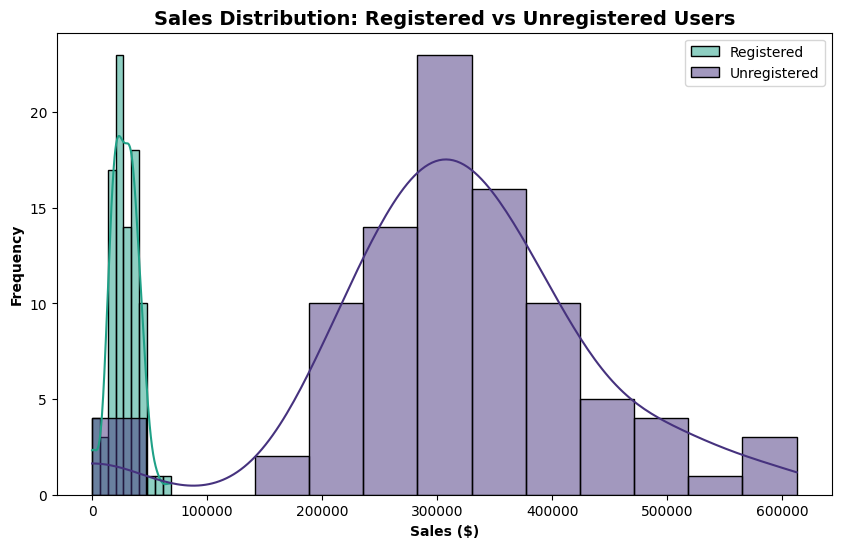

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(by_date_and_registered[1], color=sns.color_palette("viridis")[3], label='Registered', kde=True)
sns.histplot(by_date_and_registered[0], color=sns.color_palette("viridis")[0], label='Unregistered', kde=True)
plt.title("Sales Distribution: Registered vs Unregistered Users", fontsize=14, fontweight='bold')
plt.xlabel("Sales ($)", fontsize=10, fontweight='bold')
plt.ylabel("Frequency", fontsize=10, fontweight='bold')
plt.legend()
plt.show()

In [ ]:
# Mann-Whitney U Test
_, p_value = mannwhitneyu(by_date_and_registered[1], by_date_and_registered[0])
print(f"Mann-Whitney U Test: p_value = {p_value:.2e}")
print("Significant difference" if p_value < 0.05 else "No significant difference")

Mann-Whitney U Test: p_value = 8.38e-27
Significant difference


##Sessions by channel

In [ ]:
channel_data = [
    sessions_by_date_and_channel[channel].values
    for channel in sessions_by_date_and_channel.columns
]

# Kruskal-Wallis test
_, p_value = kruskal(*channel_data)
print(f"Kruskal-Wallis Test: p_value = {p_value:.2e}")
print("Significant difference" if p_value < 0.05 else "No significant difference")

Kruskal-Wallis Test: p_value = 1.40e-78
Significant difference


In [ ]:
# Mann-Whitney U Test for channel pairs
for c_1, c_2 in itertools.combinations(sessions_by_date_and_channel, 2):
    _, p_value = mannwhitneyu(sessions_by_date_and_channel[c_1], sessions_by_date_and_channel[c_2])
    print(f"{c_1} vs {c_2}:  p-value = {p_value:.2e}")
    print("Significant difference" if p_value < 0.05 else "No significant difference")

Direct vs Organic Search:  p-value = 5.37e-20
Significant difference
Direct vs Paid Search:  p-value = 1.16e-04
Significant difference
Direct vs Social Search:  p-value = 1.40e-31
Significant difference
Direct vs Undefined:  p-value = 1.08e-31
Significant difference
Organic Search vs Paid Search:  p-value = 1.05e-11
Significant difference
Organic Search vs Social Search:  p-value = 1.08e-31
Significant difference
Organic Search vs Undefined:  p-value = 1.08e-31
Significant difference
Paid Search vs Social Search:  p-value = 1.08e-31
Significant difference
Paid Search vs Undefined:  p-value = 1.08e-31
Significant difference
Social Search vs Undefined:  p-value = 7.91e-07
Significant difference


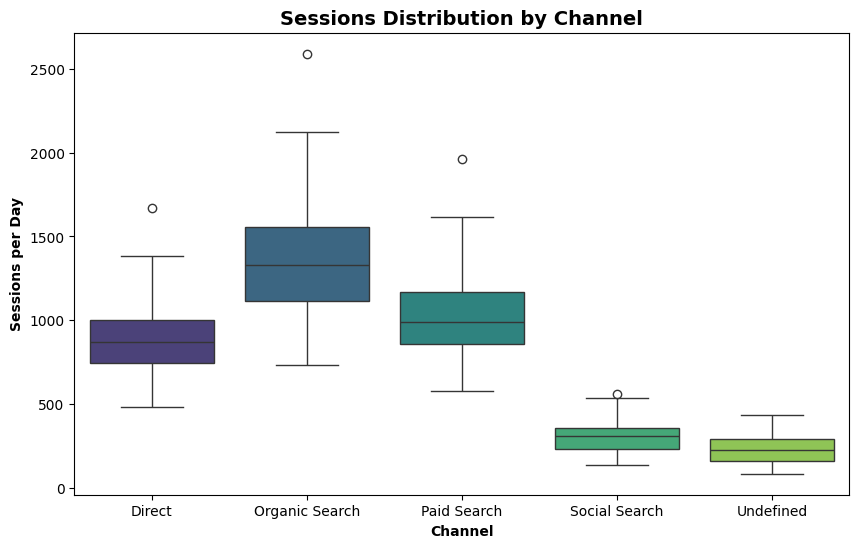

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=sessions_by_date_and_channel,palette="viridis")

plt.title("Sessions Distribution by Channel", fontsize=14, fontweight='bold')
plt.ylabel("Sessions per Day", fontsize=10, fontweight='bold')
plt.xlabel("Channel", fontsize=10, fontweight='bold')
plt.show()


##Sessions with organic search channel in Europe and Americas

In [ ]:
total_americas_sessions = df[df["continent"]=="Americas"]["ga_session_id"].count()
organic_americas_session = df[(df["continent"]=="Americas")&(df["channel"]=="Organic Search")]["ga_session_id"].count()
total_europe_sessions = df[df["continent"]=="Europe"]["ga_session_id"].count()
organic_europe_session = df[(df["continent"]=="Europe")&(df["channel"]=="Organic Search")]["ga_session_id"].count()

# Proroption Test z-test
_, p_value = sm.stats.proportions_ztest([organic_americas_session, organic_europe_session], [total_americas_sessions, total_europe_sessions])
print(f"Proroption Test: p_value = {p_value:.3f}")
print("Significant difference" if p_value < 0.05 else "No significant difference")

Proroption Test: p_value = 0.772
No significant difference


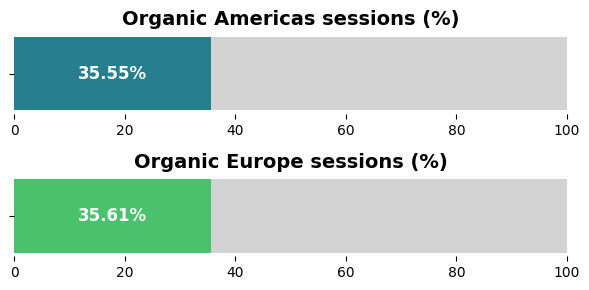

In [ ]:
organic_americas_session_percent = organic_americas_session / total_americas_sessions * 100
organic_europe_session_percent = organic_europe_session / total_europe_sessions * 100

fig, ax = plt.subplots(2, figsize=(6, 3))

ax[0].barh(["Organic Americas sessions"], [100], color='lightgray')
ax[0].barh(["Organic Americas sessions"], [organic_americas_session_percent], color=sns.color_palette("viridis")[2])
ax[0].set_xlim(0, 100)
ax[0].text(
    organic_americas_session_percent/2, 0,
    f"{organic_americas_session_percent:.2f}%",
    ha='center', va='center',
    color='white', fontsize=12, fontweight='bold'
)
ax[0].set_title("Organic Americas sessions (%)", fontsize=14, fontweight='bold')
ax[0].set_yticklabels([])
ax[0].spines[['top', 'right', 'left', 'bottom']].set_visible(False)

ax[1].barh(["Organic Europe sessions"], [100], color='lightgray')
ax[1].barh(["Organic Europe sessions"], [organic_europe_session_percent], color=sns.color_palette("viridis")[4])
ax[1].set_xlim(0, 100)
ax[1].text(
    organic_europe_session_percent/2, 0,
    f"{organic_europe_session_percent:.2f}%",
    ha='center', va='center',
    color='white', fontsize=12, fontweight='bold'
)
ax[1].set_title("Organic Europe sessions (%)", fontsize=14, fontweight='bold')
ax[1].set_yticklabels([])
ax[1].spines[['top', 'right', 'left', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()



# **Analytical Report**

## **Tableau Visualizations**

[Sales Analysis](https://public.tableau.com/app/profile/olena.sapohova/viz/SalesAnalysis_17616771890720/Metrics)




## **Basic Data Analysis**

- **Total metrics:**

Загальний обсяг продажів $31.97 млн при 33,538 замовленнях демонструє високу комерційну активність.

Середня вартість одного замовлення становить ≈ $953.

Order Conversion Rate (CR) = 9.59% — високий показник, що свідчить про ефективний маркетинг, зручний користувацький шлях і високу привабливість продукту.

Продажі у 107 країнах демонструють глобальну присутність бізнесу.


- **Sales by geography:**


Більше 55% загальних продажів приходиться на континент *Americas*.

Лідер за продажами та замовленнями - *United States*, які забезпечують ≈ 79% усіх продажів континенту *Americas* та ≈ 43.6% загальних продажів.

Аналіз середнього чека показує, що регіони з найвищими обсягами продажів не є лідерами за вартістю одного замовлення.
Лідерство у *Oceania* та *Africa*. Це свідчить про те, що клієнти з цих континентів купують найдорожчі продукти.

За країнами лідерство *Palestine* та *Bulgaria* показує, що ці ринки мають значно вищий середній чек (майже вдвічі) порівняно із загальним.

- **Sales by category:**

Топ-3 категорії (*Sofas & armchairs*, *Chairs*, *Beds*) генерують ≈ $19,45 млн, що становить ≈ 61% від загального обсягу продажів. Бізнес є висококонцентрованим навколо цих трьох груп товарів.

За кількістю замовлень лідерами є *Bookcases & shelving units* (4 місце за продажами), *Chairs* (2 місце за продажами), *Sofas & armchairs* (1 місце за продажами).

Потенціал *Tables & desks* -  ця категорія піднялася з 6-го місця за продажами на 4-е місце за кількістю замовлень, вказуючи на високу популярність.

- **Sales by category and geography:**

Для країн-лідерів за кількістю продажів та кількістю замовлень (*United States*, *India*, *Canada*, *United Kingdom*, *France*) поведінка є передбачуваною та збігається з загальними показниками:
   
  
   - Sales: *Sofas & armchairs*, *Chairs* та *Beds* — безумовні лідери продажів у всіх 5 країнах. Це основні генератори доходу.

   - Orders: *Bookcases & shelving units* — лідер за кількістю замовлень у всіх 5 країнах. Це найбільш масовий та доступний товар.

Унікальна структура попиту в країнах з високим середнім чеком:

  ***Albania*:**
   - Sales: лідери *Sofas & armchairs* та *Chairs* (схоже на загальні показники).

   - Orders: лідерство у *Chairs* та *Tables & desks*.

   Це підтверджує, що клієнти Албанії віддають перевагу дорогим, якісним одиницям меблів, особливо в сегменті *Sofas & armchairs*, *Chairs* та *Tables & desks*.

  ***Bulgaria*:**

   - Sales: абсолютний лідер — *Beds*. За ним йдуть *Sofas & armchairs* та *Chairs* (відмінність від загальних показників).

   - Orders: лідери *Bookcases & shelving units* та *Cabinets & cupboards*, *Beds* - лише на 4 місці.

Середній чек на *Beds* в Болгарії надзвичайно високий. Це підтверджує, що клієнти Болгарії віддають перевагу дорогим, якісним одиницям меблів, особливо в сегменті *Beds* та *Sofas & armchairs*.

  ***Palestine*:**

  - Sales: абсолютний лідер — *Beds*, за яким слідує *Sofas & armchairs*.

   - Orders: лідерство у *Beds* та *Bookcases & shelving units*.

Це найбільш унікальний ринок. Те, що *Beds* є лідером як за обсягом продажів, так і за кількістю замовлень, вказує на продукт-лідер з дуже високим середнім чеком.

Графіки за континентами підтверджують загальних лідерів *Sofas & armchairs* у продажах та *Bookcases & shelving units* у замовленнях. Це означає, що між континентами великої різниці у вподобаннях немає, але на рівні окремих країн із високим середнім чеком видно чіткі продуктові уподобання.

- **Sales by sessions parameters:**

  - *Desktop* (близько 59% продажів та замовлень).

  - *Chrome* (близько 68% продажів та замовлень).

  - *Web* в операційних системах (близько 57-58% продажів та замовлень).

  - *Organic Search* (понад 35% продажів та замовлень).

  - Англійська мова (понад 58% продажів та замовлень).

  
  Більшість покупок здійснюється з комп’ютерів (*Desktop*), але мобільний трафік теж має значну частку (майже 40%). Це свідчить, що сайт зручний для обох типів пристроїв, але подальший розвиток мобільної версії може дати додаткове зростання.

  Основна частка продажів припадає на браузери *Chrome* (68%) та *Safari* (23%), що вказує на стабільну технічну оптимізацію під основні браузери.
  
  Сайт добре оптимізований для веб-доступу *Web*, проте покращення мобільного UX може ще більше підвищити конверсію.

  Основні джерела продажів — *Organic Search* та *Paid Search*, які разом дають понад 60% усіх продажів.
  Це свідчить про ефективну комбінацію контент-маркетингу та рекламних кампаній.
  Сильна частка *Direct* (23%) — показник впізнаваного бренду та лояльної аудиторії.

- **Sales by accounts:**

Переважна більшість продажів (≈92%) відбувається через незареєстрованих користувачів (є значний потенціал у залученні їх до реєстрації для підвищення лояльності та повторних покупок).

Серед зареєстрованих користувачів 71.7% мають підтверджені акаунти, що є високим рівнем верифікації.

16.9% — відписані (% може бути знижений через кращу email-комунікацію чи персональні пропозиції).

Підписані користувачі генерують понад 83% продажів серед зареєстрованих (\$2.15 млн vs \$0.43 млн). Це підтверджує, що підписка має значний вплив на дохід.

Продажі від користувачів, які відписалися, все ще присутні і становлять 16.7%.

- **Accounts by geography:**

База акаунтів має сильну концентрацію у Північній Америці (переважно США та Канада), тоді як Азія та Європа демонструють потенціал для подальшого зростання.

- **Sales by date:**

Графік показує значні щоденні коливання продажів з чіткими піками та спадами (найбільші піки припадають на початок грудня (близько \$700K) та початок січня (близько \$600K)).

Продажі мають виражену сезонність і тижневий ритм — максимум у грудні та середині тижня (вівторок, середа). Це варто враховувати при плануванні акцій, рекламних кампаній.

- **Sales by date and geography:**

Загальна сезонність та щоденна коливання продажів (піки в середині грудня та на початку січня, а також падіння продажів наприкінці січня) майже повністю залежать від ринку США.

Сезонний пік продажів у грудні є глобальною тенденцією, яка спостерігається на всіх трьох континентах.

Існують локальні піки (наприклад, Індія в середині грудня до $85,000), які не збігаються з піками США.

- **Sales by date and channel:**

*Organic Search*, *Paid Search* та *Direct* зростають і падають синхронно. Це свідчить, що під час періодів підвищеного попиту (свята, акції) попит ефективно перехоплюється одразу кількома каналами — через SEO, платну рекламу та прямі заходи користувачів.

- **Sales by date for different categories:**

Всі категорії мають підвищену активність і піки продажів у грудні 2020 року.

Для більшості категорій максимальні продажі припадають на вівторок або середу.

Кожна з категорій має свою унікальну різницю між найбільшими та найменшими продажами як за датами, так і за днями тижня.

Категорії, у яких спостерігається значне зниження продажів у вихідні, можуть вимагати додаткових маркетингових активностей або акцій для компенсації зниження трафіку.

- **Sessions by channel and device:**

Основний трафік приходить із *Organic Search* та *Desktop*, але частка *Mobil* досить висока.

- **Sessions by browser and device:**

Серед браузерів домінують *Chrome* і *Safari*, що забезпечують основний обсяг сесій як на *Desktop*, так і на *Mobil* пристроях.

- **Sessions by country and channel:**

Трафік у топ-5 країнах структурно майже повністю відповідає загальній картині по компанії — домінують *Organic Search*, *Paid Search* і *Direct*.

- **Sessions by date and channel:**

Структура трафіку (*Organic Search* > *Paid Search* > *Direct*) повністю відповідає структурі продажів. *Organic Search* не тільки генерує найбільше сесій, але й є найбільш прибутковим у пікові дні.




## **Statistical analysis of relationships**

- **Sales and sessions by date:**

Існує чітка позитивна лінійна залежність між Sales та Sessions.

Sales та Sessions дуже сильно корелюють (r=0.791), і цей зв'язок є статистично значущим.

- **Sales across top-3 continents:**

Продажі між усіма Топ-3 континентами (*Americas*, *Asia*, *Europe*) сильно корелюють (всі значення r > 0.76).

Усі кореляції є позитивними (при зростанні/спаданні продажів на одному континенті з високою ймовірністю будуть зростати/спадати продажі на іншому континенті).

Усі p-value є надзвичайно малими. Це підтверджує, що виявлені зв'язки не є випадковими.

- **Sales across top-3 countries:**

Продажі в США мають сильну пряму кореляцію з продажами як в Індії, так і в Канаді (r $\approx$ 0.67). Це означає, що загальні фактори, які впливають на ріст чи падіння в США, подібним чином впливають і на продажі в Канаді та Індії.

Зв'язок між Індією та Канадою є слабшим (r = 0.501).

Усі p-value є надзвичайно малими. Це підтверджує, що виявлені зв'язки не є випадковими.


- **Sales across channels:**

Продажі між усіма парами каналів трафіку сильно або помірно корелюють, і всі ці зв'язки є статистично значущими.


- **Sales across devices:**

Кореляція між продажами з десктопів та мобільних пристроїв є надзвичайно сильною (r=0.873). Це найсильніший зв'язок серед усіх пар.

Всі зв'язки є статистично значущими.

- **Sales across top-5 categories:**

Продажі між усіма Топ-5 основними категоріями товарів корелюють позитивно і є статистично значущими.



## **Comparative Statistical Analysis**

- **Sales of registered and unregistered users:**

Був обраний Mann-Whitney U Test як найбільш відповідний непараметричний тест для порівняння середніх значень двох незалежних вибірок, які не є нормально розподіленими.

Існує статистично значуща різниця між щоденним обсягом продажів, згенерованих зареєстрованими та незареєстрованими користувачами. Незареєстровані користувачі генерують значно вищий щоденний обсяг продажів.

- **Sessions by channel:**

Kruskal-Wallis H Test — для загального порівняння всіх груп: між каналами існує статистично значуща відмінність в обсязі сесій.

Mann-Whitney U Test — для попарного порівняння груп: між кількістю сесій, згенерованих різними каналами трафіку, існують статистично значущі відмінності. *Organic Search* є статистично найсильнішим каналом за обсягом трафіку.

- **Sessions with organic search channel in Europe and Americas:**

Оскільки ми порівнюємо дві незалежні частки  у двох різних групах (континентах), було обрано Z-тест для порівняння двох пропорцій (Proportion Test).

Значення p-value =0.772\$ (є вищим за 0.05). Це означає, що статистично значущої різниці між часткою сесій, що надходять через органічний пошук в Америці (35.55%), та часткою сесій в Європі (35.61%), немає.